In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from vmc.system import BCCHeisenberg
from data import SpinCorr
from vmc.data.load import get_results, get_minimum, get_spinspin
from vmc.data.funcs import get_ievav, rel_err
from vmc.utils.serialize import load as load_opt
import matplotlib.lines as mlines
import json

plt.style.use("paper")
colors = mpl.color_sequences["Dark2"]

data_dir = "../../bcc-data/"
cm = 1 / 2.54  # convert centimetres to inches


fsize = 11

In [3]:
def load_data(path, Ni, step, max_steps, opt_max=2):
    js = [n * step for n in range(0, max_steps + 1)]
    data = np.zeros((Ni, max_steps + 1), dtype="object")
    files = np.zeros((Ni, max_steps + 1), dtype="object")
    for i in range(Ni):
        data[i, :], files[i, :] = get_results(path, nums=[i + j for j in js], opt_max=2)
    return data, files


def get_mins(data, N):
    min_energies, min_vscores, energy_std, vscore_std = [], [], [], []
    for i in range(data.shape[0]):
        min_energy = 0
        for j, results in enumerate(data[i]):
            if len(results) != 0:
                try:
                    iters, energy, vscore, acceptance, variance = get_ievav(
                        results[-1], N, True
                    )  # takes from the final results, i.e last stage
                except TypeError:
                    print("Error for ", i, j)
                energy = energy / (4 * N)
                final_energy = energy[-50:].mean()
                if final_energy < min_energy:
                    min_energy = final_energy
                    min_energy_std = energy[-50:].std()
                    min_vscore = vscore[-50:].mean()
                    min_vscore_std = vscore[-50:].std()

        min_energies.append(min_energy)
        min_vscores.append(min_vscore)
        energy_std.append(min_energy_std)
        vscore_std.append(min_vscore_std)

    return (
        np.array(min_energies),
        np.array(min_vscores),
        np.array(energy_std),
        np.array(vscore_std),
    )


# Compute relative differences
def rdiff_err(E, E_ref, sigma_E, sigma_ref):
    return np.sqrt((sigma_E / E_ref) ** 2 + (E * sigma_ref / (E_ref**2)) ** 2)

# Figure 2

In [43]:
j2cs = np.array((0.6575, 0.6775, 0.705, 0.705))
j2c_errs = np.array((0.0025, 0.0025, 0.005, 0.005))
Ns = np.array((32, 64, 128, 288))
Ls = Ns ** (1 / 3)
j2s = (
    (0.2, 0.4, 0.6, 0.62, 0.64, 0.645, 0.655, 0.66, 0.68, 0.7, 0.8, 1),
    (0.2, 0.4, 0.6, 0.62, 0.64, 0.66, 0.665, 0.675, 0.68, 0.7, 0.8, 1.0),
    (0.2, 0.4, 0.6, 0.64, 0.66, 0.68, 0.7, 0.71, 0.72, 0.74, 0.8, 1),
    (0.68, 0.7, 0.71, 0.72),
)

energies = []
R_neels = []
R_collinears = []
m_neels1 = []
m_collinears = []
base = data_dir + "processed_results/cubic/"
for N in Ns:
    energies.append(np.load(base + f"N{N}_j2_energies.npy"))
    R_neels.append(np.load(base + f"N{N}_j2_R_neel.npy"))
    R_collinears.append(np.load(base + f"N{N}_j2_R_collinear.npy"))

for N in Ns:
    try:
        m_neels1.append(np.load(base + f"N{N}_j2_m_neel.npy")[:, 0])
        m_collinears.append(np.load(base + f"N{N}_j2_m_collinear.npy")[:, 0])
    except IndexError:
        m_neels1.append(np.load(base + f"N{N}_j2_m_neel.npy"))
        m_collinears.append(np.load(base + f"N{N}_j2_m_collinear.npy"))

rel_errs = np.load(base + "N32_j2_rel_errs.npy")

In [44]:
# Load ED correlations
N = 32
j1 = 1
j2s_ed = j2s[0]
neel_ed = np.zeros((len(j2s_ed),))
collinear_ed = np.zeros((len(j2s_ed),))
q_neel = 2 * np.pi * np.array([1, 1, 1])
q_collinear = np.pi * np.array([1, 1, 1])
deltaq = np.array([np.pi / 2, 0, 0])
base = data_dir + "raw_data/exact/cubic/"
corrs = []
for j2 in j2s_ed:
    if j2 in (0.2, 0.4, 0.6, 0.7, 0.8, 1):
        corrs += [
            np.load(
                base + f"bcc_cubic_evector_422_000_0.5_0_{j1:.2f}_{j2:.2f}_szsz.npy"
            )
        ]
    elif j2 in (0.62, 0.64, 0.66):
        corrs += [
            np.load(base + f"bcc_evector_422_000_0.5_0_J={j1:.2f},{j2:.2f},_szsz.npy")
        ]
    else:
        corrs += [
            np.load(base + f"bcc_evector_422_000_0.5_0_J={j1:.3f},{j2:.3f},_szsz.npy")
        ]

system = BCCHeisenberg(lattice_shape=(4, 2, 2), J=(1, 1))
for i, j2 in enumerate(j2s_ed):
    sc = SpinCorr(corrs[i], system.graph)
    sq1, _ = sc.structure_factor(q_neel + deltaq)
    sq2, _ = sc.structure_factor(q_neel)
    neel_ed[i] = 1 - sq1 / sq2
    sq1, _ = sc.structure_factor(q_collinear + deltaq)
    sq2, _ = sc.structure_factor(q_collinear)
    collinear_ed[i] = 1 - sq1 / sq2

Using simple cubic BCC lattice with lattice shape [4 2 2]
No little group irrep specified, symmetrizing over all invariant sectors
Number of point group symmetries:  16


/Users/rajah.nutakki/repos/bcc-nqs/src/vmc/system/bcc.py:207: UserWarning: Using BCC lattice with side length <= 2, sites may be connected to each other twice due to periodic boundaries.
  warnings.warn(


N_i = N_j, assuming S is full (N,N) correlation matrix
N_i = N_j, assuming S is full (N,N) correlation matrix
N_i = N_j, assuming S is full (N,N) correlation matrix
N_i = N_j, assuming S is full (N,N) correlation matrix
N_i = N_j, assuming S is full (N,N) correlation matrix
N_i = N_j, assuming S is full (N,N) correlation matrix
N_i = N_j, assuming S is full (N,N) correlation matrix
N_i = N_j, assuming S is full (N,N) correlation matrix
N_i = N_j, assuming S is full (N,N) correlation matrix
N_i = N_j, assuming S is full (N,N) correlation matrix
N_i = N_j, assuming S is full (N,N) correlation matrix
N_i = N_j, assuming S is full (N,N) correlation matrix


/var/folders/q5/3th0qwt539db5yhyjt0j0c1w0000gp/T/ipykernel_4545/4127683412.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  neel_ed[i] = 1-sq1/sq2
/var/folders/q5/3th0qwt539db5yhyjt0j0c1w0000gp/T/ipykernel_4545/4127683412.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  collinear_ed[i] = 1-sq1/sq2


In [45]:
j2c_lit = {
    "PFFRG": 0.702,
    "ED": 0.7,
    "CC": 0.704,
    "spin_wave": 0.705,
    "RPA": 0.72,
    "linked_cluster": 0.7055,
}

In [46]:
from scipy.optimize import curve_fit


def f(L, m, c):
    return m / L**3 + c


popt1, pcov1 = curve_fit(f, Ls[1:], j2cs[1:], sigma=j2c_errs[1:])
print("Fit using N=64,128,288:", popt1, np.sqrt(np.diag(pcov1)))
popt2, pcov2 = curve_fit(f, Ls[2:], j2cs[2:], sigma=j2c_errs[2:])
print("Fit using N=128,288:", popt2, np.sqrt(np.diag(pcov2)))

Fit using N=64,128,288: [-2.5724271   0.71830097] [0.68490598 0.00905896]
Fit using N=128,288: [2.72108966e-07 7.04999999e-01] [inf inf]


/var/folders/q5/3th0qwt539db5yhyjt0j0c1w0000gp/T/ipykernel_4545/3372203518.py:7: OptimizeWarning: Covariance of the parameters could not be estimated
  popt2, pcov2 = curve_fit(f, Ls[2:], j2cs[2:],sigma=j2c_errs[2:])


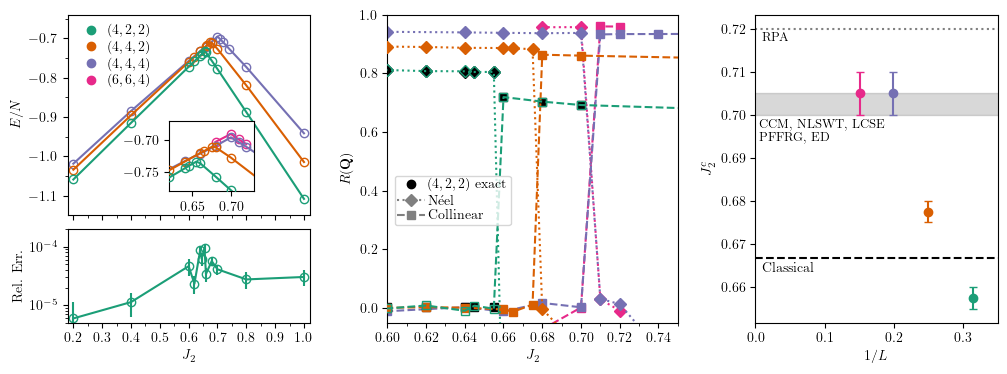

In [47]:
# Layout: two stacked axes on the left (sharing x-axis) and one tall axis on the right
fig = plt.figure(figsize=(12, 4))
gs = fig.add_gridspec(3, 3, width_ratios=[1, 1.2, 1], hspace=0.15, wspace=0.3)
mfc = "None"

ax_top = fig.add_subplot(gs[:2, 0])
ax_bot = fig.add_subplot(gs[2:, 0], sharex=ax_top)  # shares x-axis with top left
ax_middle = fig.add_subplot(gs[:, 1])  # spans both rows on the right
ax_right = fig.add_subplot(gs[:, 2])  # spans both rows on the right
n_displacement = (0, 0, 0, 0)
for n, N in enumerate(Ns[:-1]):
    ax_top.errorbar(
        j2s[n],
        energies[n][:, 0] + n_displacement[n],
        yerr=energies[n][:, 1],
        fmt="-o",
        color=colors[n],
        label=f"$N={N}$",
        markerfacecolor=mfc,
        zorder=3 - n,
    )


ax_top.set_ylabel(r"$E/N$")
ax_top.tick_params(labelbottom=False)  # hide xlabels on top plot
ax_top.set_xlim(0.18, 1.02)
ax_top.set_ylim(-1.15, -0.64)
ax_top.set_xticks(np.arange(0.2, 1.05, 0.1), minor=False)
ax_top.set_xticks(np.arange(0.25, 1.05, 0.1), minor=True)
ax_top.set_yticks(np.arange(-1.1, -0.65, 0.1), minor=False)
ax_top.set_yticks(np.arange(-1.05, -0.64, 0.1), minor=True)

inset_ax = ax_top.inset_axes([0.42, 0.12, 0.35, 0.35])
for n, N in enumerate(Ns):
    inset_ax.errorbar(
        j2s[n],
        energies[n][:, 0] + n_displacement[n],
        yerr=energies[n][:, 1],
        fmt="-o",
        color=colors[n],
        markerfacecolor=mfc,
        zorder=4 - n,
    )
inset_ax.set_xlim(0.62, 0.73)
inset_ax.set_ylim(-0.78, -0.67)

ax_bot.errorbar(
    j2s[0],
    rel_errs[:, 0],
    yerr=rel_errs[:, 1],
    marker="o",
    linestyle="-",
    color=colors[0],
    label="$N=32$",
    markerfacecolor=mfc,
)
ax_bot.set_xlabel("$J_2$")
ax_bot.set_ylabel("Rel. Err.")
ax_bot.set_yscale("log")
ax_bot.set_ylim(5e-6, 2e-4)

ylabel = r"$R(\mathbf{Q})$"
xlabel = "$J_2$"
ms = ("D", "s")
ls = (":", "--")
j2s_ed = np.array((0.2, 0.4, 0.6, 0.62, 0.64, 0.645, 0.655, 0.66, 0.68, 0.7, 0.8, 1))
ax_middle.plot(
    j2s_ed,
    neel_ed,
    marker=ms[0],
    linestyle="None",
    color="black",
    label=f"$N={N}$, Néel",
    markerfacecolor=None,
    zorder=3,
)
ax_middle.plot(
    j2s_ed,
    collinear_ed,
    marker=ms[1],
    linestyle="None",
    color="black",
    label=f"$N={N}$, Collinear",
    markerfacecolor=None,
    zorder=3,
)
for i, N in enumerate(Ns):
    if i == 1:
        mfc = None
    ax_middle.plot(
        np.array(j2s[i]),
        R_neels[i],
        marker=ms[0],
        linestyle=ls[0],
        color=colors[i],
        label=f"$N={N}$, Néel",
        markerfacecolor=mfc,
        zorder=4 - i,
    )
    ax_middle.plot(
        np.array(j2s[i]),
        R_collinears[i],
        marker=ms[1],
        linestyle=ls[1],
        color=colors[i],
        label=f"$N={N}$, Collinear",
        markerfacecolor=mfc,
        zorder=4 - i,
    )

ax_middle.set_ylabel(ylabel)
ax_middle.set_xlabel(xlabel)
# ax_middle.set_xlim(-0.1,0.1)
ax_middle.set_xlim(0.6, 0.75)
ax_middle.set_xticks(np.arange(0.6, 0.75, 0.02), minor=False)
ax_middle.set_xticks(np.arange(0.61, 0.75, 0.02), minor=True)
ax_middle.set_ylim(-0.05, 1)

lines1 = [
    mlines.Line2D(
        [], [], color=colors[0], marker="o", linestyle="None", label="$(4,2,2)$"
    ),
    mlines.Line2D(
        [], [], color=colors[1], marker="o", linestyle="None", label="$(4,4,2)$"
    ),
    mlines.Line2D(
        [], [], color=colors[2], marker="o", linestyle="None", label="$(4,4,4)$"
    ),
    mlines.Line2D(
        [], [], color=colors[3], marker="o", linestyle="None", label="$(6,6,4)$"
    ),
]
lines2 = [
    mlines.Line2D(
        [], [], color="black", marker="o", linestyle="None", label="$(4,2,2)$ exact"
    ),
    mlines.Line2D(
        [],
        [],
        color="grey",
        marker=ms[0],
        linestyle=ls[0],
        label="Néel",
        markerfacecolor=mfc,
    ),
    mlines.Line2D(
        [],
        [],
        color="grey",
        marker=ms[1],
        linestyle=ls[1],
        label="Collinear",
        markerfacecolor=mfc,
    ),
]

# ax_right.plot(1/Ls, j2cs, '--',color='black')
# L_plots = np.linspace(0.001,0.25,100)
# ax_right.plot(L_plots, f(1/L_plots, *popt1), '-',color='black')
# ax_right.errorbar(0,popt1[1],yerr = np.sqrt(pcov1[1,1]),marker='o',color='black',capsize=3)
for i, N in enumerate(Ns):
    ax_right.errorbar(
        1 / Ls[i],
        j2cs[i],
        yerr=j2c_errs[i],
        marker="o",
        color=colors[i],
        label=f"$N={N}$",
        markerfacecolor=mfc,
        capsize=3,
    )

ax_right.set_xlim(0, 0.35)
# ax_right.set_ylim(0.65,0.75)
ax_right.fill_between(
    x=[ax_right.get_xlim()[0] - 0.1, ax_right.get_xlim()[1] + 0.1],  # full x-axis span
    y1=0.7,
    y2=0.705,
    color="gray",
    alpha=0.3,
    zorder=0,
)
ax_right.axhline(y=0.72, linestyle=":", color="gray")
ax_right.axhline(y=2 / 3, linestyle="--", color="black")
ax_right.annotate(
    "CCM, NLSWT, LCSE\n PFFRG, ED",
    xy=(0.005, 0.696),
    xycoords="data",
    fontsize=9,
    va="center",
)
ax_right.annotate("RPA", xy=(0.01, 0.718), xycoords="data", fontsize=9, va="center")
ax_right.annotate(
    "Classical", xy=(0.01, 0.664), xycoords="data", fontsize=10, va="center"
)

ax_right.set_xlabel(r"$1/L$")
ax_right.set_ylabel(r"$J_{2}^c$")
ax_middle.legend(
    handles=lines2,
    bbox_to_anchor=(0.45, 0.5),
    ncols=1,
    fontsize=10,
    borderpad=0.2,  # Space inside the legend border
    labelspacing=0.2,  # Vertical space between legend entries
    handletextpad=0.2,  # Space between the icon and the text
)
ax_top.legend(
    handles=lines1,
    loc="upper left",
    ncols=1,
    fontsize=10,
    frameon=False,
    borderpad=0.2,  # Space inside the legend border
    labelspacing=0.2,  # Vertical space between legend entries
    handletextpad=0.2,  # Space between the icon and the text
)

plt.show()

# Figure 3

In [48]:
Ns = (32, 128, 256, 288)
Ls = np.array(Ns) ** (1 / 3)
jabs = (
    (0.8, 0.9, 0.95, 1, 1.025, 1.05, 1.1, 1.2),
    (0.8, 0.9, 1, 1.025, 1.0375, 1.05, 1.1, 1.2),
    (1, 1.025, 1.0375, 1.05),
    (1, 1.025, 1.05),
)

jab_crits = (1.0375, 1.03125, 1.04375, 1.0375)
jab_crit_errs = (0.0125, 0.00625, 0.00625, 0.0125)

energies = []
m_neels2 = []
m_chains = []
R_neels = []
R_chains = []
base = data_dir + "processed_results/tetragonal/"
for N in Ns:
    energies.append(np.load(f"{base}/N{N}_jab_energies.npy"))
    m_neels2.append(np.load(f"{base}/N{N}_jab_m_neel.npy"))
    m_chains.append(np.load(f"{base}/N{N}_jab_m_chains.npy"))
    R_neels.append(np.load(f"{base}/N{N}_jab_R_neel.npy"))
    R_chains.append(np.load(f"{base}/N{N}_jab_R_chains.npy"))

rel_errs = np.load(f"{base}/N32_jab_rel_errs.npy")

# ED results
ed_jabs = np.array(
    [
        0.0,
        0.2,
        0.4,
        0.6,
        0.8,
        0.9,
        0.95,
        1.0,
        1.025,
        1.05,
        1.1,
        1.15,
        1.2,
        1.4,
        1.6,
        1.8,
        2.0,
        2.2,
        2.4,
        2.6,
        2.8,
    ]
)
ed_indices = [4, 5, 6, 7, 8, 9, 10, 12]
print(ed_jabs[ed_indices])
ed_R_neel = np.load(f"{base}/R_neel_ed.npy")
ed_R_chains = np.load(f"{base}/R_chains_ed.npy")

[0.8   0.9   0.95  1.    1.025 1.05  1.1   1.2  ]


8 (8,)
8 (8,)
4 (4,)
3 (3,)


/Users/rajah.nutakki/repos/bcc-nqs/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/rajah.nutakki/repos/bcc-nqs/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


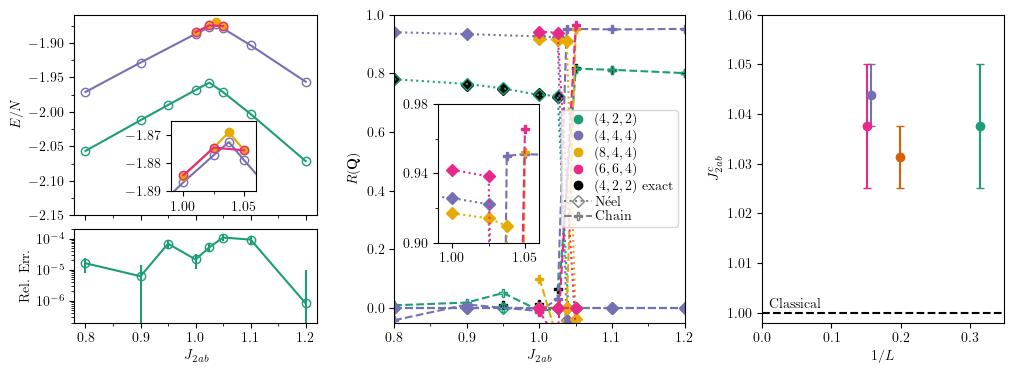

In [49]:
# Layout: two stacked axes on the left (sharing x-axis) and one tall axis on the right
fig = plt.figure(figsize=(12, 4))
gs = fig.add_gridspec(3, 3, width_ratios=[1, 1.2, 1], hspace=0.15, wspace=0.3)
ax_top = fig.add_subplot(gs[:2, 0])
ax_bot = fig.add_subplot(gs[2:, 0], sharex=ax_top)  # shares x-axis with top left
ax_middle = fig.add_subplot(gs[:, 1])  # spans both rows on the right
ax_right = fig.add_subplot(gs[:, 2])  # spans both rows on the right

mfc = "None"
n_displacement = (0, 0, 0, 0)
color_index = (colors[0], colors[2], colors[5], colors[3])
mfcs = (mfc, mfc, None, mfc)
for n, N in enumerate(Ns):
    print(len(jabs[n]), energies[n][:, 0].shape)
    ax_top.errorbar(
        jabs[n],
        energies[n][:, 0] + n_displacement[n],
        yerr=energies[n][:, 1],
        fmt="-o",
        color=color_index[n],
        label=f"$N={N}$",
        markerfacecolor=mfcs[n],
    )


ax_top.set_ylabel(r"$E/N$")
ax_top.tick_params(labelbottom=False)  # hide xlabels on top plot
# ax_top.set_xlim(0.18,1.02)
# ax_top.set_ylim(-2.075,-1.85)
ymin, ymax = -2.15, -1.85
ax_top.set_xticks(np.arange(0.8, 1.25, 0.1), minor=False)
ax_top.set_xticks(np.arange(0.85, 1.25, 0.1), minor=True)
ax_top.set_yticks(np.arange(ymin, ymax, 0.05), minor=False)
ax_top.set_yticks(np.arange(ymin + 0.025, ymax, 0.05), minor=True)

inset_ax = ax_top.inset_axes([0.4, 0.12, 0.35, 0.35])
alphas = (1, 1, 1, 1)
for n, N in enumerate(Ns):
    inset_ax.errorbar(
        jabs[n],
        energies[n][:, 0] + n_displacement[n],
        yerr=energies[n][:, 1],
        fmt="-o",
        color=color_index[n],
        markerfacecolor=mfcs[n],
        alpha=alphas[n],
    )
inset_ax.set_xlim(0.99, 1.06)
inset_ax.set_ylim(-1.89, -1.865)
inset_ax.set_xticks([1, 1.05], minor=False)
inset_ax.set_xticks([1.025], minor=True)

ax_bot.errorbar(
    jabs[0],
    rel_errs[:, 0],
    yerr=rel_errs[:, 1],
    marker="o",
    linestyle="-",
    color=colors[0],
    label="$N=32$",
    markerfacecolor=mfc,
)
ax_bot.set_xlabel(r"$J_{2ab}$")
ax_bot.set_ylabel("Rel. Err.")
ax_bot.set_yscale("log")
ax_bot.set_ylim(2e-7, 2e-4)

ylabel = r"$R(\mathbf{Q})$"
xlabel = r"$J_{2ab}$"
ms = ("D", "P")
ls = (":", "--")
mfcs = ("None", None, None, None)
# j2s_ed = np.array((0.2,0.4,0.6,0.62,0.64,0.645,0.655,0.66,0.68,0.7,0.8,1))
ax_middle.plot(
    ed_jabs[ed_indices],
    ed_R_neel[ed_indices],
    marker=ms[0],
    linestyle="None",
    color="black",
    label=f"$N={N}$, Néel",
    markerfacecolor=None,
)
ax_middle.plot(
    ed_jabs[ed_indices],
    ed_R_chains[ed_indices],
    marker=ms[1],
    linestyle="None",
    color="black",
    label=f"$N={N}$, Chains",
    markerfacecolor=None,
)

for i, N in enumerate(Ns):
    ax_middle.plot(
        np.array(jabs[i]),
        R_neels[i],
        marker=ms[0],
        linestyle=ls[0],
        color=color_index[i],
        label=f"$N={N}$, Néel",
        markerfacecolor=mfcs[i],
    )
    ax_middle.plot(
        np.array(jabs[i]),
        R_chains[i],
        marker=ms[1],
        linestyle=ls[1],
        color=color_index[i],
        label=f"$N={N}$, Chains",
        markerfacecolor=mfcs[i],
    )

ax_middle.set_ylabel(ylabel)
ax_middle.set_xlabel(xlabel)
ax_middle.set_xlim(0.8, 1.2)
ax_middle.set_ylim(-0.05, 1)
ax_middle.set_xticks(np.arange(0.8, 1.25, 0.1), minor=False)
ax_middle.set_xticks(np.arange(0.85, 1.25, 0.1), minor=True)

inset_middle = ax_middle.inset_axes([0.15, 0.26, 0.35, 0.45])
for i, N in enumerate(Ns):
    inset_middle.plot(
        np.array(jabs[i]),
        R_neels[i],
        marker=ms[0],
        linestyle=ls[0],
        color=color_index[i],
        label=f"$N={N}$, Néel",
        markerfacecolor=mfcs[i],
    )
    inset_middle.plot(
        np.array(jabs[i]),
        R_chains[i],
        marker=ms[1],
        linestyle=ls[1],
        color=color_index[i],
        label=f"$N={N}$, Chains",
        markerfacecolor=mfcs[i],
    )
inset_middle.set_xlim(0.99, 1.06)
inset_middle.set_ylim(0.9, 0.98)
inset_middle.set_xticks([1, 1.05], minor=False)
inset_middle.set_xticks([1.025], minor=True)
inset_middle.set_yticks([0.9, 0.94, 0.98], minor=False)
inset_middle.set_yticks([0.92, 0.96], minor=True)

lines1 = [
    mlines.Line2D(
        [], [], color=colors[0], marker="o", linestyle="None", label="$(4,2,2)$"
    ),
    # mlines.Line2D([],[], color = colors[1], marker='o', linestyle='None', label = '$442$'),
    mlines.Line2D(
        [], [], color=colors[2], marker="o", linestyle="None", label="$(4,4,4)$"
    ),
    mlines.Line2D(
        [], [], color=colors[5], marker="o", linestyle="None", label="$(8,4,4)$"
    ),
    mlines.Line2D(
        [], [], color=colors[3], marker="o", linestyle="None", label="$(6,6,4)$"
    ),
]
lines2 = [
    mlines.Line2D(
        [], [], color="black", marker="o", linestyle="None", label="$(4,2,2)$ exact"
    ),
    mlines.Line2D(
        [],
        [],
        color="grey",
        marker=ms[0],
        linestyle=ls[0],
        label="Néel",
        markerfacecolor=mfc,
    ),
    mlines.Line2D(
        [],
        [],
        color="grey",
        marker=ms[1],
        linestyle=ls[1],
        label="Chain",
        markerfacecolor=mfc,
    ),
]

for i, N in enumerate(Ns):
    ax_right.errorbar(
        1 / Ls[i],
        jab_crits[i],
        yerr=jab_crit_errs[i],
        marker="o",
        color=colors[i],
        label=f"$N={N}$",
        markerfacecolor=None,
        capsize=3,
    )

ax_right.set_xlabel(r"$1/L$")
ax_right.set_ylabel(r"$J_{2ab}^c$")
ax_right.set_xlim(0, 0.35)
ax_right.set_ylim(0.998, 1.06)
ax_right.axhline(y=1, linestyle="--", color="black")
ax_right.annotate(
    "Classical", xy=(0.01, 1.0015), xycoords="data", fontsize=10, va="center"
)
ax_middle.legend(
    handles=lines1 + lines2,
    loc="center right",
    ncols=1,
    fontsize=10,
    borderpad=0.2,  # Space inside the legend border
    labelspacing=0.2,  # Vertical space between legend entries
    handletextpad=0.2,  # Space between the icon and the text
)
# plt.savefig("tetragonal_mainfig.pdf", bbox_inches='tight', pad_inches=0.1, dpi=150)
plt.show()

# Figure 10

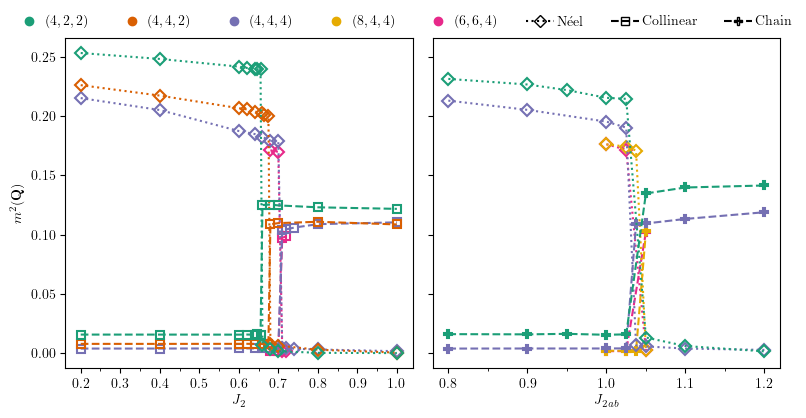

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True, sharey=True)
ylabel = r"$m^2(\mathbf Q)$"
xlabels = ("$J_{2}$", "$J_{2ab}$")
ms1 = ("D", "s")
ms2 = ("D", "P")
ls = (":", "--")
mfc = "None"
mew = 1.5

# J2 plot
for i, N in enumerate(Ns):
    axes[0].plot(
        np.array(j2s[i]),
        m_neels1[i],
        marker=ms1[0],
        linestyle=ls[0],
        color=colors[i],
        zorder=4 - i,
        markerfacecolor=mfc,
        markeredgewidth=mew,
    )
    axes[0].plot(
        np.array(j2s[i]),
        m_collinears[i],
        marker=ms1[1],
        linestyle=ls[1],
        color=colors[i],
        zorder=4 - i,
        markerfacecolor=mfc,
        markeredgewidth=mew,
    )

# J2ab plot
color_index = (colors[0], colors[2], colors[5], colors[3])
for i, N in enumerate(Ns):
    axes[1].plot(
        np.array(jabs[i]),
        m_neels2[i],
        marker=ms2[0],
        linestyle=ls[0],
        color=color_index[i],
        zorder=4 - i,
        markerfacecolor=mfc,
        markeredgewidth=mew,
    )
    axes[1].plot(
        np.array(jabs[i]),
        m_chains[i],
        marker=ms2[1],
        linestyle=ls[1],
        color=color_index[i],
        zorder=4 - i,
        markerfacecolor=mfc,
        markeredgewidth=mew,
    )

axes[0].set_ylabel(ylabel)
for i, ax in enumerate(axes):
    ax.set_xlabel(xlabels[i])

axes[0].set_xticks(np.arange(0.2, 1.05, 0.1), minor=False)
axes[0].set_xticks(np.arange(0.25, 1.05, 0.1), minor=True)

axes[1].set_xticks(np.arange(0.8, 1.25, 0.1), minor=False)
axes[1].set_xticks(np.arange(0.85, 1.25, 0.1), minor=True)

lines1 = [
    mlines.Line2D(
        [], [], color=colors[0], marker="o", linestyle="None", label="$(4,2,2)$"
    ),
    mlines.Line2D(
        [], [], color=colors[1], marker="o", linestyle="None", label="$(4,4,2)$"
    ),
    mlines.Line2D(
        [], [], color=colors[2], marker="o", linestyle="None", label="$(4,4,4)$"
    ),
    mlines.Line2D(
        [], [], color=colors[5], marker="o", linestyle="None", label="$(8,4,4)$"
    ),
    mlines.Line2D(
        [], [], color=colors[3], marker="o", linestyle="None", label="$(6,6,4)$"
    ),
    mlines.Line2D(
        [],
        [],
        color="black",
        marker=ms1[0],
        linestyle=ls[0],
        label="Néel",
        markerfacecolor=mfc,
    ),
    mlines.Line2D(
        [],
        [],
        color="black",
        marker=ms1[1],
        linestyle=ls[1],
        label="Collinear",
        markerfacecolor=mfc,
    ),
    mlines.Line2D(
        [],
        [],
        color="black",
        marker=ms2[1],
        linestyle=ls[1],
        label="Chain",
        markerfacecolor=mfc,
    ),
]


fig.legend(
    handles=lines1,
    bbox_to_anchor=(1.01, 1.05),
    ncols=8,
    fontsize=10,
    frameon=False,
    handletextpad=0.2,
)
# plt.savefig("order_parameters.pdf", bbox_inches='tight', pad_inches=0.1, dpi=150)
plt.show()

# Figure 4

In [3]:
# Momentum
N = 64
base = data_dir + "raw_data/cubic/442cubic_J2_0.2_ksectors/"
j1 = 1
k_sectors = np.arange(12)
data = np.zeros((len(k_sectors), 5), dtype="object")
files = np.zeros((len(k_sectors), 5), dtype="object")
for i in k_sectors:
    data[i, :], files[i, :] = get_results(
        base,
        nums=(
            i,
            i + len(k_sectors),
            i + 2 * len(k_sectors),
            i + 3 * len(k_sectors),
            i + 4 * len(k_sectors),
        ),
        opt_max=2,
    )

energies_k, energy_mean_k, vscores, vscore_mean, min_runs, runs1, _ = get_minimum(
    data,
    np.arange(len(k_sectors)),
    lambda i, j: i + j * len(k_sectors),
    N,
    len(data[0, 0][0]["Energy"]["iters"]),
    k_sectors,
)

['../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/0/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/12/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/24/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/36/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/48/']
['../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/1/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/13/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/25/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/37/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/49/']
['../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/2/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/14/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/26/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/38/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/50/']
['../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/3/', '../../b

In [4]:
# Little Group
base = data_dir + "raw_data/cubic/442cubic_J2_0.2_ksectors/59/continue"
j1 = 1
little_group_sectors = np.arange(10)
data = np.zeros((len(little_group_sectors), 5), dtype="object")
files = np.zeros((len(little_group_sectors), 5), dtype="object")
for i in little_group_sectors:
    data[i, :], files[i, :] = get_results(
        base,
        nums=(
            i,
            i + len(little_group_sectors),
            i + 2 * len(little_group_sectors),
            i + 3 * len(little_group_sectors),
            i + 4 * len(little_group_sectors),
        ),
        opt_max=2,
    )

energies_l, energy_mean_l, vscores, vscore_mean, min_runs, runs, _ = get_minimum(
    data,
    np.arange(len(little_group_sectors)),
    lambda i, j: i + j * len(little_group_sectors),
    N,
    len(data[0, 0][0]["Energy"]["iters"]),
    little_group_sectors,
)

base = data_dir + "raw_data/cubic/442cubic_J2_0.2_ksectors/59/exp_stage2_"
projected_results = np.zeros((len(little_group_sectors),), dtype="object")
for i in little_group_sectors:
    with open(f"{base}{i}.json", "r") as f:
        projected_results[i] = json.load(f)

projected_energies_l = (
    [
        float(projected_results[i]["energy"]["mean"]) / (4 * N)
        for i in little_group_sectors
    ],
    [
        float(projected_results[i]["energy"]["error_of_mean"]) / (4 * N)
        for i in little_group_sectors
    ],
)

['../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/59/continue0/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/59/continue10/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/59/continue20/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/59/continue30/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/59/continue40/']
['../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/59/continue1/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/59/continue11/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/59/continue21/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/59/continue31/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/59/continue41/']
['../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/59/continue2/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/59/continue12/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/59/continue22/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksec

In [5]:
# Spin parity
base = data_dir + "raw_data/cubic/442cubic_J2_0.2_ksectors/59/continue40/continue"
j1 = 1
sectors = [1, 0]  # note other way around in results
data = np.zeros((len(sectors), 5), dtype="object")
files = np.zeros((len(sectors), 5), dtype="object")
for i in range(2):
    j = sectors[i]
    data[j, :], files[j, :] = get_results(
        base, nums=(5 * i, 5 * i + 1, 5 * i + 2, 5 * i + 3, 5 * i + 4), opt_max=2
    )

sectors = [-1, 1]
energies_p, energy_mean_p, vscores, vscore_mean, min_runs, runs, _ = get_minimum(
    data,
    sectors,
    lambda i, j: 5 * i + j,
    N,
    len(data[0, 0][0]["Energy"]["iters"]),
    sectors,
)

base = data_dir + "raw_data/cubic/442cubic_J2_0.2_ksectors/59/exp_stage3_"
projected_results = np.zeros((len(sectors),), dtype="object")
tsectors = (0, 1)
for i in tsectors:
    with open(f"{base}{i}correct.json", "r") as f:
        projected_results[i] = json.load(f)

projected_energies_p = (
    [
        float(projected_results[i]["energy"]["mean"]) / (4 * N)
        for i in range(len(sectors))
    ],
    [
        float(projected_results[i]["energy"]["error_of_mean"]) / (4 * N)
        for i in range(len(sectors))
    ],
)

['../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/59/continue40/continue0/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/59/continue40/continue1/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/59/continue40/continue2/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/59/continue40/continue3/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/59/continue40/continue4/']
['../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/59/continue40/continue5/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/59/continue40/continue6/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/59/continue40/continue7/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/59/continue40/continue8/', '../../bcc-data/raw_data/cubic/442cubic_J2_0.2_ksectors/59/continue40/continue9/']
group = -1
-1
run = 0 (total run = 0):, <E> = -1.0299672918147373+-8.82620489396328e-05, <V> = 0.0029991812534933397+-0.00010903897678819721, <A> = 0.15912410736083984


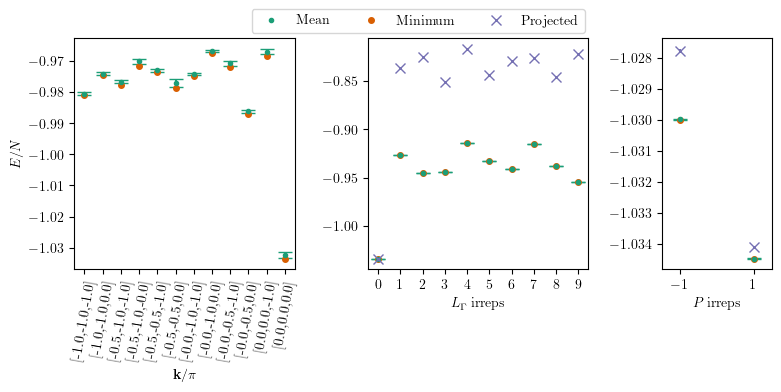

In [6]:
fig = plt.figure(figsize=(9, 3))
gs = fig.add_gridspec(1, 3, width_ratios=[2, 2, 1], hspace=0, wspace=0.4)
mfc = "None"
msize1 = 4
msize2 = 7

axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
ks = np.array(
    [
        [-1.0, -1.0, -1.0],
        [-1.0, -1.0, 0.0],
        [-0.5, -1.0, -1.0],
        [-0.5, -1.0, -0.0],
        [-0.5, -0.5, -1.0],
        [-0.5, -0.5, 0.0],
        [-0.0, -1.0, -1.0],
        [-0.0, -1.0, 0.0],
        [-0.0, -0.5, -1.0],
        [-0.0, -0.5, 0.0],
        [0.0, 0.0, -1.0],
        [0.0, 0.0, 0.0],
    ]
)
ls = np.arange(10)
ps = [-1, 1]
ylabels = [r"$E/N$", "", r"", r"$\Delta_i$"]
xlabels = [
    r"$\mathbf k/\pi$",
    r"$L_{\Gamma} \: \mathrm{irreps}$",
    r"$P \: \mathrm{irreps}$",
    r"$N$",
]
kticks = [f"[{ks[i, 0]:.1f},{ks[i, 1]:.1f},{ks[i, 2]:.1f}]" for i in range(len(ks))]

# k-sectors
axes[0].errorbar(
    k_sectors,
    energy_mean_k[:, 0],
    yerr=energy_mean_k[:, 1],
    color=colors[0],
    marker=".",
    linestyle="None",
    capsize=5,
)
axes[0].plot(
    k_sectors,
    energies_k[:, 0],
    color=colors[1],
    marker="o",
    linestyle="None",
    markersize=msize1,
)
axes[0].set_xticks(k_sectors, labels=kticks, rotation=80)

fig.legend(
    [
        plt.Line2D(
            [0], [0], color=colors[0], marker=".", linestyle="None", label="Mean"
        ),
        plt.Line2D(
            [0],
            [0],
            color=colors[1],
            marker="o",
            linestyle="None",
            label="Minimum",
            markersize=msize1,
        ),
        plt.Line2D(
            [0],
            [0],
            color=colors[2],
            marker="x",
            linestyle="None",
            label="Projected",
            markersize=msize2,
        ),
    ],
    ["Mean", "Minimum", "Projected"],
    bbox_to_anchor=(0.7, 1),
    ncol=3,
    frameon=True,
)

# little group sectors
axes[1].errorbar(
    ls,
    energy_mean_l[:, 0],
    yerr=energy_mean_l[:, 1],
    color=colors[0],
    marker=".",
    linestyle="None",
    capsize=5,
)
axes[1].plot(
    ls,
    energies_l[:, 0],
    color=colors[1],
    marker="o",
    linestyle="None",
    markersize=msize1,
)
axes[1].errorbar(
    ls,
    projected_energies_l[0],
    yerr=projected_energies_l[1],
    color=colors[2],
    marker="x",
    linestyle="None",
    markersize=msize2,
)
axes[1].set_xticks(ls)

# spin parity sectors
axes[2].errorbar(
    ps,
    energy_mean_p[:, 0],
    yerr=energy_mean_p[:, 1],
    color=colors[0],
    marker=".",
    linestyle="None",
    capsize=5,
)
axes[2].plot(
    ps,
    energies_p[:, 0],
    color=colors[1],
    marker="o",
    linestyle="None",
    markersize=msize1,
)
axes[2].errorbar(
    ps,
    projected_energies_p[0],
    yerr=projected_energies_p[1],
    color=colors[2],
    marker="x",
    linestyle="None",
    markersize=msize2,
)
axes[2].set_xticks(ps)
axes[2].set_xlim(-1.5, 1.5)

for i, ax in enumerate(axes):
    ax.set_ylabel(ylabels[i])
    ax.set_xlabel(xlabels[i])

plt.show()

# Figure 5

In [51]:
N = 32
patch_sizes = (2, 8, 16)
j2s = (0.2, 0.4, 0.6, 0.625, 0.65, 0.675, 0.7, 0.8, 1, 2.5)
min_energies1, vscores1 = (
    np.zeros((len(patch_sizes), len(j2s), 2)),
    np.zeros((len(patch_sizes), len(j2s), 2)),
)
all_data = np.zeros((2, len(patch_sizes), len(j2s), 3), dtype="object")
# Patch size 2
data, files = load_data(
    "/Users/rajah.nutakki/cluster/projects/jeanzay/fm_groundstates/bcc/01_08_25/422cubic_variousJ2_p111/",
    Ni=len(j2s),
    step=len(j2s),
    max_steps=2,
)
min_energies1[0, :, 0], vscores1[0, :, 0], min_energies1[0, :, 1], vscores1[0, :, 1] = (
    get_mins(data, N)
)
all_data[0, 0, :, :] = data
# Patch size 8
data, files = load_data(
    "/Users/rajah.nutakki/cluster/projects/jeanzay/fm_groundstates/bcc/01_08_25/422cubic_variousJ2_p221/",
    Ni=len(j2s),
    step=len(j2s),
    max_steps=2,
)
min_energies1[1, :, 0], vscores1[1, :, 0], min_energies1[1, :, 1], vscores1[1, :, 1] = (
    get_mins(data, N)
)
all_data[0, 1, :, :] = data
# Patch size 16
data, files = load_data(
    "/Users/rajah.nutakki/cluster/projects/jeanzay/fm_groundstates/bcc/04_08_25/422cubic_variousJ2_p222/",
    Ni=len(j2s),
    step=len(j2s),
    max_steps=2,
)
min_energies1[2, :, 0], vscores1[2, :, 0], min_energies1[2, :, 1], vscores1[2, :, 1] = (
    get_mins(data, N)
)
all_data[0, 2, :, :] = data
# ED data
ed_energies = [
    np.load(
        f"/Users/rajah.nutakki/cluster/projects/jeanzay/fm_groundstates/bcc/exact/bcc_cubic_evalue_422_000_0.5_0_{1:.2f}_{j2:.2f}.npy"
    )
    / (4 * N)
    for j2 in j2s
]

['/Users/rajah.nutakki/cluster/projects/jeanzay/fm_groundstates/bcc/01_08_25/422cubic_variousJ2_p111/0/', '/Users/rajah.nutakki/cluster/projects/jeanzay/fm_groundstates/bcc/01_08_25/422cubic_variousJ2_p111/10/', '/Users/rajah.nutakki/cluster/projects/jeanzay/fm_groundstates/bcc/01_08_25/422cubic_variousJ2_p111/20/']
['/Users/rajah.nutakki/cluster/projects/jeanzay/fm_groundstates/bcc/01_08_25/422cubic_variousJ2_p111/1/', '/Users/rajah.nutakki/cluster/projects/jeanzay/fm_groundstates/bcc/01_08_25/422cubic_variousJ2_p111/11/', '/Users/rajah.nutakki/cluster/projects/jeanzay/fm_groundstates/bcc/01_08_25/422cubic_variousJ2_p111/21/']
['/Users/rajah.nutakki/cluster/projects/jeanzay/fm_groundstates/bcc/01_08_25/422cubic_variousJ2_p111/2/', '/Users/rajah.nutakki/cluster/projects/jeanzay/fm_groundstates/bcc/01_08_25/422cubic_variousJ2_p111/12/', '/Users/rajah.nutakki/cluster/projects/jeanzay/fm_groundstates/bcc/01_08_25/422cubic_variousJ2_p111/22/']
['/Users/rajah.nutakki/cluster/projects/jeanza

/Users/rajah.nutakki/repos/bcc-nqs/src/vmc/data/funcs.py:11: RuntimeWarning: overflow encountered in square
  return N * varE / (E**2)


In [52]:
rel_diffs = np.zeros((2, len(patch_sizes) - 1, len(j2s), 2))
for i in range(1, len(patch_sizes)):
    rel_diffs[0, i - 1, :, 0] = rel_err(
        min_energies1[i, :, 0], min_energies1[0, :, 0], abs_numerator=False
    )
    rel_diffs[0, i - 1, :, 1] = rdiff_err(
        min_energies1[i, :, 0],
        min_energies1[0, :, 0],
        min_energies1[i, :, 1],
        min_energies1[0, :, 1],
    )

/var/folders/q5/3th0qwt539db5yhyjt0j0c1w0000gp/T/ipykernel_4545/1187342221.py:36: RuntimeWarning: divide by zero encountered in divide
  return np.sqrt((sigma_E/E_ref)**2 + (E*sigma_ref/(E_ref**2))**2)
/var/folders/q5/3th0qwt539db5yhyjt0j0c1w0000gp/T/ipykernel_4545/1187342221.py:36: RuntimeWarning: invalid value encountered in divide
  return np.sqrt((sigma_E/E_ref)**2 + (E*sigma_ref/(E_ref**2))**2)


/var/folders/q5/3th0qwt539db5yhyjt0j0c1w0000gp/T/ipykernel_4545/3263833159.py:20: RuntimeWarning: All-NaN slice encountered
  ax.fill_between(j2s, np.nanmax(rel_diffs[j,:,:,1],axis=0), -np.nanmax(rel_diffs[j,:,:,1],axis=0), color=colors[j], alpha= af)
/var/folders/q5/3th0qwt539db5yhyjt0j0c1w0000gp/T/ipykernel_4545/3263833159.py:21: RuntimeWarning: All-NaN slice encountered
  ax.plot(j2s, np.nanmax(rel_diffs[j,:,:,1],axis=0), color=colors[j], linestyle=':')
/var/folders/q5/3th0qwt539db5yhyjt0j0c1w0000gp/T/ipykernel_4545/3263833159.py:22: RuntimeWarning: All-NaN slice encountered
  ax.plot(j2s, -np.nanmax(rel_diffs[j,:,:,1],axis=0), color=colors[j], linestyle=':')


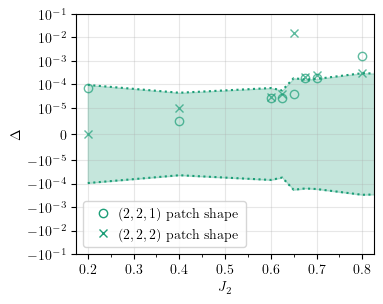

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(10 * cm, 8 * cm))

ms = ("o", "x")
ec = ("black", "grey")
cs = 2
ct = 1.2
ls = "None"
a = 0.7
mfc = "None"
xmin, xmax = 0.175, 0.825
af = 0.25
j = 0
for i in range(2):
    ax.plot(
        j2s,
        rel_diffs[0, i, :, 0],
        marker=ms[i],
        linestyle=ls,
        alpha=a,
        color=colors[0],
        markerfacecolor=mfc,
    )

# Error for different patchings is about the same, plot error for each J2 for each system size
ax.fill_between(
    j2s,
    np.nanmax(rel_diffs[j, :, :, 1], axis=0),
    -np.nanmax(rel_diffs[j, :, :, 1], axis=0),
    color=colors[j],
    alpha=af,
)
ax.plot(j2s, np.nanmax(rel_diffs[j, :, :, 1], axis=0), color=colors[j], linestyle=":")
ax.plot(j2s, -np.nanmax(rel_diffs[j, :, :, 1], axis=0), color=colors[j], linestyle=":")
# Constant error
# ax.fill_between((xmin,xmax), 2*[np.nanmax(rel_diffs[j,:,:,1])], 2*[-np.nanmax(rel_diffs[j,:,:,1])], color=colors[j], alpha= af)
# ax.plot((xmin,xmax), 2*[np.nanmax(rel_diffs[j,:,:,1])], color=colors[j], linestyle=':')
# ax.plot((xmin,xmax), 2*[-np.nanmax(rel_diffs[j,:,:,1])], color=colors[j], linestyle=':')

ax.set_ylabel(r"$\Delta$")
ax.grid(True, alpha=0.3)
ax.set_yscale("symlog", linthresh=1e-5)
ax.set_ylim(-1e-1, 1e-1)
ax.set_xticks(np.arange(0.2, 1.1, 0.1), minor=False)
ax.set_xticks(np.arange(0.25, 1.1, 0.1), minor=True)
ax.set_xlim(xmin, xmax)

handles = [
    mlines.Line2D(
        [],
        [],
        color=colors[0],
        marker=ms[0],
        linestyle="None",
        label=r"$(2,2,1)$ patch shape",
        markerfacecolor=mfc,
    ),
    mlines.Line2D(
        [],
        [],
        color=colors[0],
        marker=ms[1],
        linestyle="None",
        label=r"$(2,2,2)$ patch shape",
        markerfacecolor=mfc,
    ),
]

# Place the two legends above the plot
legend = ax.legend(
    handles=handles, loc="lower left", ncol=1, frameon=True, handletextpad=0.2
)
ax.set_xlabel(r"$J_2$")
plt.tight_layout()
plt.show()

# Figure 7a

In [7]:
N = 32
sign_rules = ("None", r"$J_1$", r"$J_2$")
j2s = (0.2, 0.4, 0.6, 0.625, 0.65, 0.675, 0.7, 0.8, 1, 2.5)
min_energies, vscores = (
    np.zeros((len(sign_rules), len(j2s), 2)),
    np.zeros((len(sign_rules), len(j2s), 2)),
)
all_data = np.zeros((len(sign_rules), len(j2s), 3), dtype="object")
# No sign rule
data, files = load_data(
    "/Users/rajah.nutakki/cluster/projects/jeanzay/fm_groundstates/bcc/01_08_25/422cubic_variousJ2_p111/",
    Ni=len(j2s),
    step=len(j2s),
    max_steps=2,
)
min_energies[0, :, 0], vscores[0, :, 0], min_energies[0, :, 1], vscores[0, :, 1] = (
    get_mins(data, N)
)
all_data[0, :, :] = data
# J1 sign rule
data, files = load_data(
    "/Users/rajah.nutakki/cluster/projects/jeanzay/fm_groundstates/bcc/08_08_25/422cubic_j1signrule/",
    Ni=len(j2s),
    step=len(j2s),
    max_steps=2,
)
min_energies[1, :, 0], vscores[1, :, 0], min_energies[1, :, 1], vscores[1, :, 1] = (
    get_mins(data, N)
)
all_data[1, :, :] = data
# J2 sign rule
data, files = load_data(
    "/Users/rajah.nutakki/cluster/projects/jeanzay/fm_groundstates/bcc/08_08_25/422cubic_j2signrule/",
    Ni=len(j2s),
    step=len(j2s),
    max_steps=2,
)
min_energies[2, :, 0], vscores[2, :, 0], min_energies[2, :, 1], vscores[2, :, 1] = (
    get_mins(data, N)
)
all_data[2, :, :] = data

['/Users/rajah.nutakki/cluster/projects/jeanzay/fm_groundstates/bcc/01_08_25/422cubic_variousJ2_p111/0/', '/Users/rajah.nutakki/cluster/projects/jeanzay/fm_groundstates/bcc/01_08_25/422cubic_variousJ2_p111/10/', '/Users/rajah.nutakki/cluster/projects/jeanzay/fm_groundstates/bcc/01_08_25/422cubic_variousJ2_p111/20/']
['/Users/rajah.nutakki/cluster/projects/jeanzay/fm_groundstates/bcc/01_08_25/422cubic_variousJ2_p111/1/', '/Users/rajah.nutakki/cluster/projects/jeanzay/fm_groundstates/bcc/01_08_25/422cubic_variousJ2_p111/11/', '/Users/rajah.nutakki/cluster/projects/jeanzay/fm_groundstates/bcc/01_08_25/422cubic_variousJ2_p111/21/']
['/Users/rajah.nutakki/cluster/projects/jeanzay/fm_groundstates/bcc/01_08_25/422cubic_variousJ2_p111/2/', '/Users/rajah.nutakki/cluster/projects/jeanzay/fm_groundstates/bcc/01_08_25/422cubic_variousJ2_p111/12/', '/Users/rajah.nutakki/cluster/projects/jeanzay/fm_groundstates/bcc/01_08_25/422cubic_variousJ2_p111/22/']
['/Users/rajah.nutakki/cluster/projects/jeanza

/Users/rajah.nutakki/repos/bcc-nqs/src/vmc/data/funcs.py:11: RuntimeWarning: overflow encountered in square
  return N * varE / (E**2)


In [8]:
rel_diffs = np.zeros((len(sign_rules) - 1, len(j2s), 2))
for i in range(1, len(sign_rules)):
    rel_diffs[i - 1, :, 0] = rel_err(
        min_energies[i, :, 0], min_energies[0, :, 0], abs_numerator=False
    )
    rel_diffs[i - 1, :, 1] = rdiff_err(
        min_energies[i, :, 0],
        min_energies[0, :, 0],
        min_energies[i, :, 1],
        min_energies[0, :, 1],
    )

/Users/rajah.nutakki/repos/bcc-nqs/src/vmc/data/funcs.py:23: RuntimeWarning: invalid value encountered in divide
  return (E - E_ref) / np.abs(E_ref)
/var/folders/q5/3th0qwt539db5yhyjt0j0c1w0000gp/T/ipykernel_6077/1187342221.py:36: RuntimeWarning: divide by zero encountered in divide
  return np.sqrt((sigma_E/E_ref)**2 + (E*sigma_ref/(E_ref**2))**2)
/var/folders/q5/3th0qwt539db5yhyjt0j0c1w0000gp/T/ipykernel_6077/1187342221.py:36: RuntimeWarning: invalid value encountered in divide
  return np.sqrt((sigma_E/E_ref)**2 + (E*sigma_ref/(E_ref**2))**2)
/Users/rajah.nutakki/repos/bcc-nqs/src/vmc/data/funcs.py:23: RuntimeWarning: divide by zero encountered in divide
  return (E - E_ref) / np.abs(E_ref)


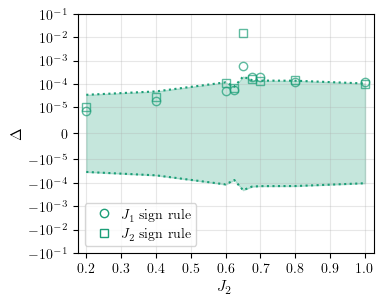

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10 * cm, 8 * cm))

ms = ("o", "s")
ec = ("black", "grey")
cs = 2
ct = 1.2
ls = "None"
a = 0.7
mfc = "None"
xmin, xmax = 0.175, 1.025
af = 0.25

for i in range(2):
    ax.plot(
        j2s,
        rel_diffs[i, :, 0],
        marker=ms[i],
        linestyle=ls,
        alpha=a,
        color=colors[0],
        markerfacecolor=mfc,
    )

# Error for different patchings is about the same, plot error for each J2 for each system size
ax.fill_between(
    j2s,
    np.nanmax(rel_diffs[:, :, 1], axis=0),
    -np.nanmax(rel_diffs[:, :, 1], axis=0),
    color=colors[0],
    alpha=af,
)
ax.plot(j2s, np.nanmax(rel_diffs[:, :, 1], axis=0), color=colors[0], linestyle=":")
ax.plot(j2s, -np.nanmax(rel_diffs[:, :, 1], axis=0), color=colors[0], linestyle=":")
# Constant error
# ax.fill_between((xmin,xmax), 2*[np.nanmax(rel_diffs[j,:,:,1])], 2*[-np.nanmax(rel_diffs[j,:,:,1])], color=colors[j], alpha= af)
# ax.plot((xmin,xmax), 2*[np.nanmax(rel_diffs[j,:,:,1])], color=colors[j], linestyle=':')
# ax.plot((xmin,xmax), 2*[-np.nanmax(rel_diffs[j,:,:,1])], color=colors[j], linestyle=':')

ax.set_ylabel(r"$\Delta$", fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_yscale("symlog", linthresh=1e-5)
ax.set_ylim(-1e-1, 1e-1)
ax.set_xlim(xmin, xmax)
ax.set_xticks(np.arange(0.2, 1.1, 0.1))

handles = [
    mlines.Line2D(
        [],
        [],
        color=colors[0],
        marker=ms[0],
        linestyle="None",
        label=r"$J_1$" + " sign rule",
        markerfacecolor=mfc,
    ),
    mlines.Line2D(
        [],
        [],
        color=colors[0],
        marker=ms[1],
        linestyle="None",
        label=r"$J_2$" + " sign rule",
        markerfacecolor=mfc,
    ),
]

# Place the two legends above the plot
legend = ax.legend(
    handles=handles, loc="lower left", ncol=1, frameon=True, handletextpad=0.2
)
ax.set_xlabel(r"$J_2$", fontsize=11)
plt.tight_layout()
plt.show()

# Figure 7b

In [12]:
# Cubic avg. sign results
Ns = (32, 64, 128, 288)
base = data_dir + "processed_results/cubic/"
j2_32 = np.array([0.2, 0.4, 0.6, 0.62, 0.64, 0.645, 0.655, 0.66, 0.68, 0.7, 0.8, 1.0])
j1_signs_32 = np.load(base + "N32_j2_j1_signs.npy")
j2_signs_32 = np.load(base + "N32_j2_j2_signs.npy")
j2_64 = np.array([0.2, 0.4, 0.6, 0.62, 0.64, 0.66, 0.665, 0.675, 0.68, 0.7, 0.8, 1.0])
j1_signs_64 = np.load(base + "N64_j2_j1_signs.npy")
j2_signs_64 = np.load(base + "N64_j2_j2_signs.npy")
j2_128 = np.array((0.2, 0.4, 0.6, 0.64, 0.66, 0.68, 0.7, 0.71, 0.72, 0.74, 0.8, 1))
j1_signs_128 = np.load(base + "N128_j2_j1_signs.npy")
j2_signs_128 = np.load(base + "N128_j2_j2_signs.npy")
j2_288 = np.array((0.68, 0.7, 0.72))
j1_signs_288 = np.load(base + "N288_j2_j1_signs.npy")
j2_signs_288 = np.load(base + "N288_j2_j2_signs.npy")
j2s = (j2_32, j2_64, j2_128, j2_288)
j1_signs = (j1_signs_32, j1_signs_64, j1_signs_128, j1_signs_288)
j2_signs = (j2_signs_32, j2_signs_64, j2_signs_128, j2_signs_288)
# Distored avg. sign results
Ns_distorted = (32, 64, 128, 256)
base = data_dir + "processed_results/tetragonal/"
jabs_32 = (0.8, 0.9, 0.95, 1, 1.025, 1.05, 1.1, 1.2)
j1_signs_32 = np.load(base + "N32_jab_j1_signs.npy")
j2_signs_32 = np.load(base + "N32_jab_j2_signs.npy")
jabs_128 = (0.8, 0.9, 1, 1.025, 1.0375, 1.05, 1.1, 1.2)
j1_signs_128 = np.load(base + "N128_jab_j1_signs.npy")
j2_signs_128 = np.load(base + "N128_jab_j2_signs.npy")
jabs_256 = (1, 1.025, 1.0375, 1.05)
j1_signs_256 = np.load(base + "N256_jab_j1_signs.npy")
j2_signs_256 = np.load(base + "N256_jab_j2_signs.npy")
jabs_288 = (1, 1.025, 1.05)
j1_signs_288 = np.load(base + "N288_jab_j1_signs.npy")
j2_signs_288 = np.load(base + "N288_jab_j2_signs.npy")
jabs = (jabs_32, jabs_128, jabs_256, jabs_288)
j1_signs_distorted = (j1_signs_32, j1_signs_128, j1_signs_256, j1_signs_288)
j2_signs_distorted = (j2_signs_32, j2_signs_128, j2_signs_256, j2_signs_288)

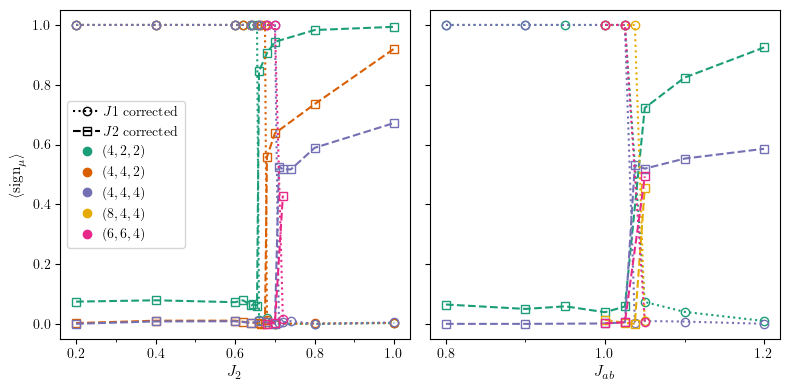

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True, sharey=True)
mfc = "None"
# n_displacements = (0.0,0.05,0.1,0.15)
n_displacements = (0, 0, 0, 0)
for n, N in enumerate(Ns):
    axes[0].plot(
        j2s[n],
        j1_signs[n] + n_displacements[n],
        ":o",
        color=colors[n],
        label=f"$N={N}$",
        markerfacecolor=mfc,
    )
    axes[0].plot(
        j2s[n],
        j2_signs[n],
        "--s",
        color=colors[n],
        label=f"$N={N}$",
        markerfacecolor=mfc,
    )
axes[0].set_xlabel("$J_2$", fontsize=fsize)
axes[0].set_ylabel(r"$\langle \mathrm{sign}_{\mu} \rangle$", fontsize=fsize)
color_index = (colors[0], colors[2], colors[5], colors[3])
for n, N in enumerate(Ns_distorted):
    axes[1].plot(
        jabs[n],
        j1_signs_distorted[n] + n_displacements[n],
        ":o",
        color=color_index[n],
        label=f"$N={N}$",
        markerfacecolor=mfc,
    )
    axes[1].plot(
        jabs[n],
        j2_signs_distorted[n],
        "--s",
        color=color_index[n],
        label=f"$N={N}$",
        markerfacecolor=mfc,
    )
axes[1].set_xlabel(r"$J_{ab}$", fontsize=fsize)


axes[0].set_xticks(np.arange(min(j2s[0]), max(j2s[0]) + 0.1, 0.2), minor=False)
axes[0].set_xticks(np.arange(min(j2s[0]) + 0.1, max(j2s[0]) + 0.1, 0.2), minor=True)
axes[1].set_xticks(np.arange(min(jabs[0]), max(jabs[0]) + 0.1, 0.2), minor=False)
axes[1].set_xticks(np.arange(min(jabs[0]) + 0.1, max(jabs[0]) + 0.1, 0.2), minor=True)

lines = (
    mlines.Line2D(
        [],
        [],
        color="black",
        linestyle=":",
        marker="o",
        label="$J1$ corrected",
        markerfacecolor=mfc,
    ),
    mlines.Line2D(
        [],
        [],
        color="black",
        linestyle="--",
        marker="s",
        label="$J2$ corrected",
        markerfacecolor=mfc,
    ),
    mlines.Line2D(
        [], [], color=colors[0], marker="o", linestyle="None", label="$(4,2,2)$"
    ),
    mlines.Line2D(
        [], [], color=colors[1], marker="o", linestyle="None", label="$(4,4,2)$"
    ),
    mlines.Line2D(
        [], [], color=colors[2], marker="o", linestyle="None", label="$(4,4,4)$"
    ),
    mlines.Line2D(
        [], [], color=colors[5], marker="o", linestyle="None", label="$(8,4,4)$"
    ),
    mlines.Line2D(
        [], [], color=colors[3], marker="o", linestyle="None", label="$(6,6,4)$"
    ),
)

axes[0].legend(handles=lines, fontsize=fsize - 1, handletextpad=0.2)
plt.show()

# Figure 8

## 422

In [9]:
N = 32
base1 = data_dir + "raw_data/cubic/422cubic_J2/"
min_runs1 = [30, 31, 22, 43, 44, 25, 46, 37, 38, 39]
j2s_1 = (0.2, 0.4, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.8, 1)
base2 = data_dir + "raw_data/cubic/422cubic_J2_critical/"
min_runs2 = [0, 8]
j2s_2 = (0.645, 0.655)
j2s = np.sort(np.array(j2s_1 + j2s_2))
i1 = 0
i2 = 0
files = []
for j2 in j2s:
    if j2 in j2s_1:
        idx = min_runs1[i1]
        i1 += 1
        files.append(base1 + f"{int(idx)}/continue0/continue1/final_exp.json")
    elif j2 in j2s_2:
        idx = min_runs2[i2]
        i2 += 1
        files.append(base2 + f"{int(idx)}/final_exp.json")

results = []
systems = []
for i, j2 in enumerate(j2s):
    with open(files[i], "r") as f:
        results.append(json.load(f))
        _, system, _, _, _ = load_opt(files[i].replace("final_exp.json", "opt.json"))
        systems.append(system)

Using simple cubic BCC lattice with lattice shape [4 2 2]
Momentum sector k = [0. 0. 0.]
Using little group irrep 0:
Little group elements: 
 ['Id()', 'Rot(180°)[0,0,1]', 'Rot(180°)[0,1,0]', 'Rot(180°)[1,0,0]', 'Rot(180°)[0,1,1]', 'Rot(90°)[1,0,0]', 'Rot(90°)[-1,0,0]', 'Rot(180°)[0,1,-1]', 'Inv()', 'Refl[0,0,1]', 'Refl[0,1,0]', 'Refl[1,0,0]', 'Refl[0,1,1]', 'RotoRefl(90°)[-1,0,0]', 'RotoRefl(90°)[1,0,0]', 'Refl[0,1,-1]']
Little group characters: 
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Momentum sector = (0.0, 0.0, 0.0)
Using simple cubic BCC lattice with lattice shape [4 2 2]
Momentum sector k = [0. 0. 0.]
Using little group irrep 0:
Little group elements: 
 ['Id()', 'Rot(180°)[0,0,1]', 'Rot(180°)[0,1,0]', 'Rot(180°)[1,0,0]', 'Rot(180°)[0,1,1]', 'Rot(90°)[1,0,0]', 'Rot(90°)[-1,0,0]', 'Rot(180°)[0,1,-1]', 'Inv()', 'Refl[0,0,1]', 'Refl[0,1,0]', 'Refl[1,0,0]', 'Refl[0,1,1]', 'RotoRefl(90°)[-1,0,0]', 'RotoRefl(90°)[1,0,0]', 'Refl[0,1,-1]']
Little group characters: 
 [1. 1. 1. 1.

In [10]:
n = 9
print(f"J2 = {j2s[n]}")
res = results[n]
SzSz, SzSz_error = get_spinspin(res, 2, N, string="SzSz_t")
SpSm, SpSm_error = get_spinspin(res, 2, N, string="SpSm_t")
SpSm, SpSm_error = 0.5 * np.array((SpSm, SpSm_error))
S_error = np.sqrt(SzSz_error**2 + SpSm_error**2)
scorr = SpinCorr(SzSz + SpSm, system.graph)
qmin, qmax = 0, 4 * np.pi
deltaqx = np.pi / 2
deltaqy = np.pi
Qx = np.arange(qmin, qmax + 0.1, deltaqx)
Qy = np.arange(qmin, qmax + 0.1, deltaqy)
Qz = np.array([np.pi])
Q = np.zeros((len(Qx), len(Qy), len(Qz), 3))
for i, qx in enumerate(Qx):
    for j, qy in enumerate(Qy):
        for k, qz in enumerate(Qz):
            Q[i, j, k] = np.array([qx, qy, qz])

S_q, _ = scorr.structure_factor(Q)
Sq_plot = np.zeros((len(Qx), len(Qy)))
for i, qx in enumerate(Qx):
    for j, qy in enumerate(Qy):
        Sq_plot[i, j] = S_q[i, j, 0]  # Take hl0 cut

J2 = 0.7
N_i != N_j, assuming S is (Nbasis, N) correlation matrix


/var/folders/q5/3th0qwt539db5yhyjt0j0c1w0000gp/T/ipykernel_7977/3194205997.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  Sq_plot[i,j] = S_q[i,j,0]  # Take hl0 cut


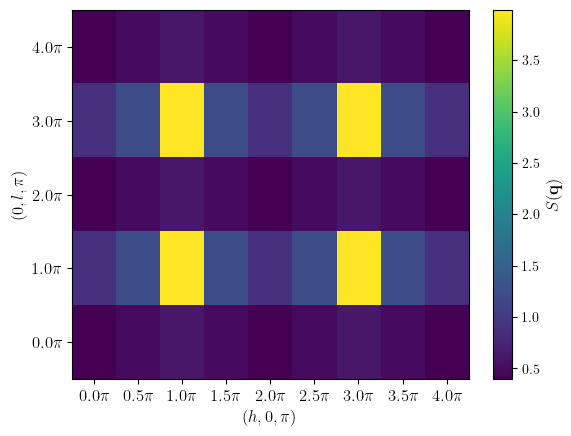

In [11]:
plt.imshow(
    Sq_plot.transpose(),
    extent=(
        qmin - deltaqx / 2,
        qmax + deltaqx / 2,
        qmin - deltaqy / 2,
        qmax + deltaqy / 2,
    ),
    origin="lower",
    aspect="auto",
)
cbar = plt.colorbar()
fsize = 12
plt.xlabel(r"$(h,0,\pi)$", fontsize=fsize)
plt.ylabel(r"$(0,l,\pi)$", fontsize=fsize)
plt.xticks(Qx, [f"{i / np.pi:.1f}" + r"$\pi$" for i in Qx], fontsize=fsize)
plt.yticks(Qy, [f"{i / np.pi:.1f}" + r"$\pi$" for i in Qy], fontsize=fsize)
cbar.set_label(r"$S(\mathbf{q})$", fontsize=fsize)
# plt.savefig(f"N32_j2_{j2s[n]:.3f}_Sq.pdf", dpi=150,bbox_inches='tight',pad_inches=0.1)
plt.show()

## 442

In [19]:
N = 64
base1 = data_dir + "raw_data/cubic/442cubic_J2/"
min_runs1 = [30, 1, 22, 3, 44, 25, 36, 17, 48, 49]
j2s_1 = (0.2, 0.4, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.8, 1)
base2 = data_dir + "raw_data/cubic/442cubic_J2_critical/"
min_runs2 = [3, 5]
j2s_2 = (0.665, 0.675)
j2s = np.sort(np.array(j2s_1 + j2s_2))
i1 = 0
i2 = 0
files = []
for j2 in j2s:
    if j2 in j2s_1:
        idx = min_runs1[i1]
        i1 += 1
        if idx in (44, 25, 36):
            files.append(base1 + f"{int(idx)}/continue1/continue2/final_exp.json")
        else:
            files.append(base1 + f"{int(idx)}/continue1/continue1/final_exp.json")
    elif j2 in j2s_2:
        idx = min_runs2[i2]
        i2 += 1
        files.append(base2 + f"{int(idx)}/final_exp.json")

results = []
systems = []
for i, j2 in enumerate(j2s):
    with open(files[i], "r") as f:
        results.append(json.load(f))
        _, system, _, _, _ = load_opt(files[i].replace("final_exp.json", "opt.json"))
        systems.append(system)

Using simple cubic BCC lattice with lattice shape [4 4 2]
Momentum sector k = [0. 0. 0.]
Using little group irrep 0:
Little group elements: 
 ['Id()', 'Rot(180°)[0,0,1]', 'Rot(180°)[0,1,0]', 'Rot(180°)[1,0,0]', 'Rot(90°)[0,0,1]', 'Rot(90°)[0,0,-1]', 'Rot(180°)[1,-1,0]', 'Rot(180°)[-1,-1,0]', 'Inv()', 'Refl[0,0,1]', 'Refl[0,1,0]', 'Refl[1,0,0]', 'RotoRefl(90°)[0,0,-1]', 'RotoRefl(90°)[0,0,1]', 'Refl[1,-1,0]', 'Refl[1,1,0]']
Little group characters: 
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


/Users/rajah.nutakki/repos/bcc-nqs/src/vmc/system/bcc.py:207: UserWarning: Using BCC lattice with side length <= 2, sites may be connected to each other twice due to periodic boundaries.
  warnings.warn(


Momentum sector = (0.0, 0.0, 0.0)
Using simple cubic BCC lattice with lattice shape [4 4 2]
Momentum sector k = [0. 0. 0.]
Using little group irrep 0:
Little group elements: 
 ['Id()', 'Rot(180°)[0,0,1]', 'Rot(180°)[0,1,0]', 'Rot(180°)[1,0,0]', 'Rot(90°)[0,0,1]', 'Rot(90°)[0,0,-1]', 'Rot(180°)[1,-1,0]', 'Rot(180°)[-1,-1,0]', 'Inv()', 'Refl[0,0,1]', 'Refl[0,1,0]', 'Refl[1,0,0]', 'RotoRefl(90°)[0,0,-1]', 'RotoRefl(90°)[0,0,1]', 'Refl[1,-1,0]', 'Refl[1,1,0]']
Little group characters: 
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Momentum sector = (0.0, 0.0, 0.0)
Using simple cubic BCC lattice with lattice shape [4 4 2]
Momentum sector k = [0. 0. 0.]
Using little group irrep 0:
Little group elements: 
 ['Id()', 'Rot(180°)[0,0,1]', 'Rot(180°)[0,1,0]', 'Rot(180°)[1,0,0]', 'Rot(90°)[0,0,1]', 'Rot(90°)[0,0,-1]', 'Rot(180°)[1,-1,0]', 'Rot(180°)[-1,-1,0]', 'Inv()', 'Refl[0,0,1]', 'Refl[0,1,0]', 'Refl[1,0,0]', 'RotoRefl(90°)[0,0,-1]', 'RotoRefl(90°)[0,0,1]', 'Refl[1,-1,0]', 'Refl[1,1,0]']
L

In [20]:
n = 9
print(f"J2 = {j2s[n]}")
res = results[n]
SzSz, SzSz_error = get_spinspin(res, 2, N, string="SzSz_t")
SpSm, SpSm_error = get_spinspin(res, 2, N, string="SpSm_t")
SpSm, SpSm_error = 0.5 * np.array((SpSm, SpSm_error))
S_error = np.sqrt(SzSz_error**2 + SpSm_error**2)
scorr = SpinCorr(SzSz + SpSm, system.graph)
qmin, qmax = 0, 4 * np.pi
deltaqx = np.pi / 2
deltaqy = np.pi / 2
Qx = np.arange(qmin, qmax + 0.1, deltaqx)
Qy = np.arange(qmin, qmax + 0.1, deltaqy)
Qz = np.array([np.pi])
Q = np.zeros((len(Qx), len(Qy), len(Qz), 3))
for i, qx in enumerate(Qx):
    for j, qy in enumerate(Qy):
        for k, qz in enumerate(Qz):
            Q[i, j, k] = np.array([qx, qy, qz])

S_q, _ = scorr.structure_factor(Q)
Sq_plot = np.zeros((len(Qx), len(Qy)))
for i, qx in enumerate(Qx):
    for j, qy in enumerate(Qy):
        Sq_plot[i, j] = S_q[i, j, 0]  # Take hll cut

J2 = 0.7
N_i != N_j, assuming S is (Nbasis, N) correlation matrix


/var/folders/q5/3th0qwt539db5yhyjt0j0c1w0000gp/T/ipykernel_7977/2002665699.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  Sq_plot[i,j] = S_q[i,j,0]  # Take hll cut


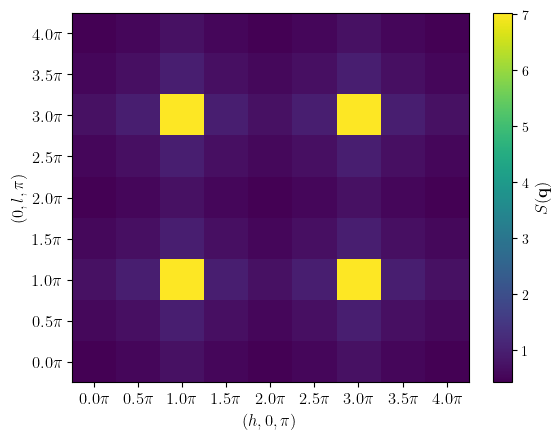

In [22]:
plt.imshow(
    Sq_plot.transpose(),
    extent=(
        qmin - deltaqx / 2,
        qmax + deltaqx / 2,
        qmin - deltaqy / 2,
        qmax + deltaqy / 2,
    ),
    origin="lower",
    aspect="auto",
)
cbar = plt.colorbar()
fsize = 12
plt.xlabel(r"$(h,0,\pi)$", fontsize=fsize)
plt.ylabel(r"$(0,l,\pi)$", fontsize=fsize)
plt.xticks(Qx, [f"{i / np.pi:.1f}" + r"$\pi$" for i in Qx], fontsize=fsize)
plt.yticks(Qy, [f"{i / np.pi:.1f}" + r"$\pi$" for i in Qy], fontsize=fsize)
cbar.set_label(r"$S(\mathbf{q})$", fontsize=fsize)
plt.show()

## 444

In [25]:
N = 128
base = data_dir + "raw_data/cubic/444_cubic_J2/"
base2 = data_dir + "raw_data/cubic/444_J20.71/"
min_runs = [0.0, 12.0, 24.0, 25.0, 15.0, 16.0, 17.0, 2, 7.0, 8.0, 20.0, 21.0]
j2s = (0.2, 0.4, 0.6, 0.64, 0.66, 0.68, 0.7, 0.71, 0.72, 0.74, 0.8, 1)
files = []
for i, j2 in enumerate(j2s):
    indx = int(min_runs[i])
    if j2 == 0.71:
        files.append(base2 + f"{indx}/continue0/continue0/final_exp.json")
    else:
        files.append(base + f"{indx}/continue0/continue3/final_exp.json")

results = []
systems = []
for i, j2 in enumerate(j2s):
    with open(files[i], "r") as f:
        results.append(json.load(f))
        _, system, _, _, _ = load_opt(files[i].replace("final_exp.json", "opt.json"))
        systems.append(system)

Using simple cubic BCC lattice with lattice shape [4 4 4]
Momentum sector k = [0. 0. 0.]
Using little group irrep 0:
Little group elements: 
 ['Id()', 'Rot(120°)[1,1,1]', 'Rot(120°)[1,-1,-1]', 'Rot(120°)[-1,1,-1]', 'Rot(120°)[-1,-1,1]', 'Rot(120°)[-1,-1,-1]', 'Rot(120°)[-1,1,1]', 'Rot(120°)[1,-1,1]', 'Rot(120°)[1,1,-1]', 'Rot(180°)[0,0,1]', 'Rot(180°)[0,1,0]', 'Rot(180°)[1,0,0]', 'Rot(90°)[0,0,1]', 'Rot(180°)[0,1,1]', 'Rot(90°)[1,0,0]', 'Rot(90°)[-1,0,0]', 'Rot(180°)[0,1,-1]', 'Rot(90°)[0,-1,0]', 'Rot(180°)[1,0,-1]', 'Rot(180°)[1,0,1]', 'Rot(90°)[0,1,0]', 'Rot(90°)[0,0,-1]', 'Rot(180°)[1,-1,0]', 'Rot(180°)[-1,-1,0]', 'Inv()', 'RotoRefl(60°)[-1,-1,-1]', 'RotoRefl(60°)[-1,1,1]', 'RotoRefl(60°)[1,-1,1]', 'RotoRefl(60°)[1,1,-1]', 'RotoRefl(60°)[1,1,1]', 'RotoRefl(60°)[1,-1,-1]', 'RotoRefl(60°)[-1,1,-1]', 'RotoRefl(60°)[-1,-1,1]', 'Refl[0,0,1]', 'Refl[0,1,0]', 'Refl[1,0,0]', 'RotoRefl(90°)[0,0,-1]', 'Refl[0,1,1]', 'RotoRefl(90°)[-1,0,0]', 'RotoRefl(90°)[1,0,0]', 'Refl[0,1,-1]', 'RotoRefl(90

In [28]:
n = 6
print(f"J2 = {j2s[n]}")
res = results[n]
SzSz, SzSz_error = get_spinspin(res, 2, N, string="SzSz_t")
SpSm, SpSm_error = get_spinspin(res, 2, N, string="SpSm_t")
SpSm, SpSm_error = 0.5 * np.array((SpSm, SpSm_error))
S_error = np.sqrt(SzSz_error**2 + SpSm_error**2)
scorr = SpinCorr(SzSz + SpSm, system.graph)
qmin, qmax = 0, 4 * np.pi
deltaqx = np.pi / 2
deltaqy = np.pi / 2
Qx = np.arange(qmin, qmax + 0.1, deltaqx)
Qy = np.arange(qmin, qmax + 0.1, deltaqy)
Qz = np.array([0])
Q = np.zeros((len(Qx), len(Qy), len(Qz), 3))
for i, qx in enumerate(Qx):
    for j, qy in enumerate(Qy):
        for k, qz in enumerate(Qz):
            Q[i, j, k] = np.array([qx, qy, qz])

S_q, _ = scorr.structure_factor(Q)
Sq_plot = np.zeros((len(Qx), len(Qy)))
for i, qx in enumerate(Qx):
    for j, qy in enumerate(Qy):
        Sq_plot[i, j] = S_q[i, j, 0]  # Take hll cut

J2 = 0.7
N_i != N_j, assuming S is (Nbasis, N) correlation matrix


/var/folders/q5/3th0qwt539db5yhyjt0j0c1w0000gp/T/ipykernel_7977/3312086755.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  Sq_plot[i,j] = S_q[i,j,0]  # Take hll cut


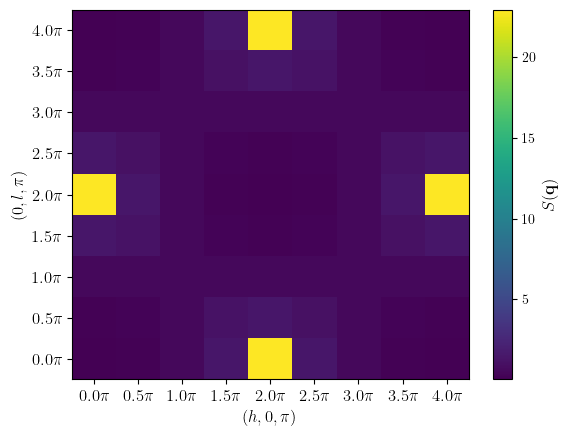

In [29]:
plt.imshow(
    Sq_plot.transpose(),
    extent=(
        qmin - deltaqx / 2,
        qmax + deltaqx / 2,
        qmin - deltaqy / 2,
        qmax + deltaqy / 2,
    ),
    origin="lower",
    aspect="auto",
)
cbar = plt.colorbar()
fsize = 12
plt.xlabel(r"$(h,0,\pi)$", fontsize=fsize)
plt.ylabel(r"$(0,l,\pi)$", fontsize=fsize)
plt.xticks(Qx, [f"{i / np.pi:.1f}" + r"$\pi$" for i in Qx], fontsize=fsize)
plt.yticks(Qy, [f"{i / np.pi:.1f}" + r"$\pi$" for i in Qy], fontsize=fsize)
cbar.set_label(r"$S(\mathbf{q})$", fontsize=fsize)
plt.show()

# Figure 9

## 422

In [35]:
N = 32
t = 0.985
base = data_dir + "raw_data/tetragonal/422cubic_Jab/"
base1 = data_dir + "raw_data/tetragonal/422cubic_crit1/"
base2 = data_dir + "raw_data/tetragonal/422cubic_crit2/"
min_runs = [8, 1, 2, 3, 20, 5, 22, 7]
j1 = 1
jc = -4.9
jabs = (0.8, 0.9, 0.95, 1, 1.025, 1.05, 1.1, 1.2)
files = []
for i, jab in enumerate(jabs):
    if jab == 1:
        files.append(base2 + "2/continue0/continue0/final_exp.json")
    elif jab == 1.05:
        files.append(base1 + "1/continue0/continue0/final_exp.json")
    else:
        j = min_runs[i]
        files.append(base + f"{int(j)}/continue0/continue0/final_exp.json")

results = []
systems = []
for i, jab in enumerate(jabs):
    with open(files[i], "r") as f:
        results.append(json.load(f))
        _, system, _, _, _ = load_opt(files[i].replace("final_exp.json", "opt.json"))
        systems.append(system)

Using simple cubic BCC lattice with lattice shape [4 2 2]
Momentum sector k = [0. 0. 0.]
Using little group irrep 0:
Little group elements: 
 ['Id()', 'Rot(180°)[0,0,1]', 'Rot(180°)[0,1,0]', 'Rot(180°)[1,0,0]', 'Inv()', 'Refl[0,0,1]', 'Refl[0,1,0]', 'Refl[1,0,0]']
Little group characters: 
 [1. 1. 1. 1. 1. 1. 1. 1.]


/Users/rajah.nutakki/repos/bcc-nqs/src/vmc/system/bcc.py:207: UserWarning: Using BCC lattice with side length <= 2, sites may be connected to each other twice due to periodic boundaries.
  warnings.warn(


Momentum sector = (0.0, 0.0, 0.0)
Using simple cubic BCC lattice with lattice shape [4 2 2]
Momentum sector k = [0. 0. 0.]
Using little group irrep 0:
Little group elements: 
 ['Id()', 'Rot(180°)[0,0,1]', 'Rot(180°)[0,1,0]', 'Rot(180°)[1,0,0]', 'Inv()', 'Refl[0,0,1]', 'Refl[0,1,0]', 'Refl[1,0,0]']
Little group characters: 
 [1. 1. 1. 1. 1. 1. 1. 1.]
Momentum sector = (0.0, 0.0, 0.0)
Using simple cubic BCC lattice with lattice shape [4 2 2]
Momentum sector k = [0. 0. 0.]
Using little group irrep 0:
Little group elements: 
 ['Id()', 'Rot(180°)[0,0,1]', 'Rot(180°)[0,1,0]', 'Rot(180°)[1,0,0]', 'Inv()', 'Refl[0,0,1]', 'Refl[0,1,0]', 'Refl[1,0,0]']
Little group characters: 
 [1. 1. 1. 1. 1. 1. 1. 1.]
Momentum sector = (0.0, 0.0, 0.0)
Using simple cubic BCC lattice with lattice shape [4 2 2]
Momentum sector k = [0. 0. 0.]
Using little group irrep 0:
Little group elements: 
 ['Id()', 'Rot(180°)[0,0,1]', 'Rot(180°)[0,1,0]', 'Rot(180°)[1,0,0]', 'Inv()', 'Refl[0,0,1]', 'Refl[0,1,0]', 'Refl[1,0,0]

In [36]:
n = 5
print(f"Jab = {jabs[n]}")
res = results[n]
SzSz, SzSz_error = get_spinspin(res, 2, N, string="SzSz_t")
SpSm, SpSm_error = get_spinspin(res, 2, N, string="SpSm_t")
SpSm, SpSm_error = 0.5 * np.array((SpSm, SpSm_error))
S_error = np.sqrt(SzSz_error**2 + SpSm_error**2)
scorr = SpinCorr(SzSz + SpSm, system.graph)
qmin, qmax = 0, 4 * np.pi
deltaqx = np.pi / 2
deltaqy = np.pi
Qx = np.arange(qmin, qmax + 0.1, deltaqx)
Qy = np.arange(qmin, qmax + 0.1, deltaqy)
Qz = np.array([2 * np.pi / t])
Q = np.zeros((len(Qx), len(Qy), len(Qz), 3))
for i, qx in enumerate(Qx):
    for j, qy in enumerate(Qy):
        for k, qz in enumerate(Qz):
            Q[i, j, k] = np.array([qx, qy, qz])

S_q, _ = scorr.structure_factor(Q)
Sq_plot = np.zeros((len(Qx), len(Qy)))
for i, qx in enumerate(Qx):
    for j, qy in enumerate(Qy):
        Sq_plot[i, j] = S_q[i, j, 0]  # Take hl0 cut

Jab = 1.05
N_i != N_j, assuming S is (Nbasis, N) correlation matrix


/var/folders/q5/3th0qwt539db5yhyjt0j0c1w0000gp/T/ipykernel_7977/236290863.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  Sq_plot[i,j] = S_q[i,j,0]  # Take hl0 cut


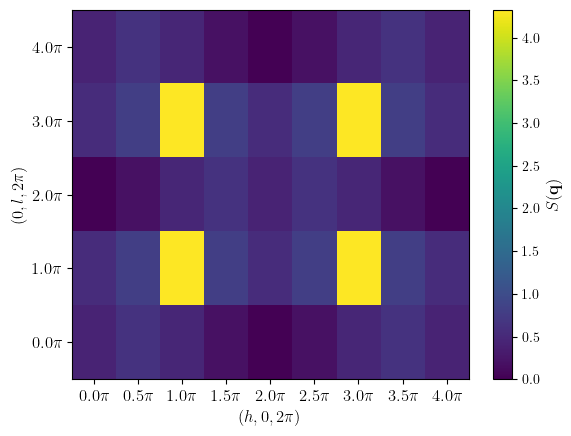

In [37]:
plt.imshow(
    Sq_plot.transpose(),
    extent=(
        qmin - deltaqx / 2,
        qmax + deltaqx / 2,
        qmin - deltaqy / 2,
        qmax + deltaqy / 2,
    ),
    origin="lower",
    aspect="auto",
)
cbar = plt.colorbar()
fsize = 12
plt.xlabel(r"$(h,0,2\pi)$", fontsize=fsize)
plt.ylabel(r"$(0,l,2\pi)$", fontsize=fsize)
plt.xticks(Qx, [f"{i / np.pi:.1f}" + r"$\pi$" for i in Qx], fontsize=fsize)
plt.yticks(Qy, [f"{i / np.pi:.1f}" + r"$\pi$" for i in Qy], fontsize=fsize)
cbar.set_label(r"$S(\mathbf{q})$", fontsize=fsize)
plt.show()

## 444

In [42]:
N = 128
base = data_dir + "raw_data/tetragonal/444_Jab/"
base2 = data_dir + "raw_data/tetragonal/tet444_Jab1.025/"
base3 = data_dir + "raw_data/tetragonal/444_jab1.0375/"
j1 = 1
jc = -4.9
jabs = (0.8, 0.9, 1, 1.025, 1.0375, 1.05, 1.1, 1.2)
min_runs = [12, 1, 2, 1, 0, 15, 4, 11]
files = []
for i, jab in enumerate(jabs):
    if jab == 1.025:
        files.append(base2 + f"{min_runs[i]}/continue0/continue0/final_exp.json")
    elif jab == 1.0375:
        files.append(base3 + f"{min_runs[i]}/continue0/continue0/final_exp.json")
    else:
        files.append(base + f"{min_runs[i]}/continue0/continue1/final_exp.json")

results = []
systems = []
for i, jab in enumerate(jabs):
    with open(files[i], "r") as f:
        results.append(json.load(f))
        _, system, _, _, _ = load_opt(files[i].replace("final_exp.json", "opt.json"))
        systems.append(system)

Using simple cubic BCC lattice with lattice shape [4 4 4]
Momentum sector k = [0. 0. 0.]
Using little group irrep 0:
Little group elements: 
 ['Id()', 'Rot(180°)[0,0,1]', 'Rot(180°)[0,1,0]', 'Rot(180°)[1,0,0]', 'Rot(90°)[0,0,1]', 'Rot(90°)[0,0,-1]', 'Rot(180°)[1,-1,0]', 'Rot(180°)[-1,-1,0]', 'Inv()', 'Refl[0,0,1]', 'Refl[0,1,0]', 'Refl[1,0,0]', 'RotoRefl(90°)[0,0,-1]', 'RotoRefl(90°)[0,0,1]', 'Refl[1,-1,0]', 'Refl[1,1,0]']
Little group characters: 
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Momentum sector = (0.0, 0.0, 0.0)
Using simple cubic BCC lattice with lattice shape [4 4 4]
Momentum sector k = [0. 0. 0.]
Using little group irrep 0:
Little group elements: 
 ['Id()', 'Rot(180°)[0,0,1]', 'Rot(180°)[0,1,0]', 'Rot(180°)[1,0,0]', 'Rot(90°)[0,0,1]', 'Rot(90°)[0,0,-1]', 'Rot(180°)[1,-1,0]', 'Rot(180°)[-1,-1,0]', 'Inv()', 'Refl[0,0,1]', 'Refl[0,1,0]', 'Refl[1,0,0]', 'RotoRefl(90°)[0,0,-1]', 'RotoRefl(90°)[0,0,1]', 'Refl[1,-1,0]', 'Refl[1,1,0]']
Little group characters: 
 [1. 1. 1

In [43]:
n = 2
print(f"Jab = {jabs[n]}")
res = results[n]
SzSz, SzSz_error = get_spinspin(res, 2, N, string="SzSz_t")
SpSm, SpSm_error = get_spinspin(res, 2, N, string="SpSm_t")
SpSm, SpSm_error = 0.5 * np.array((SpSm, SpSm_error))
S_error = np.sqrt(SzSz_error**2 + SpSm_error**2)
scorr = SpinCorr(SzSz + SpSm, system.graph)
qmin, qmax = 0, 4 * np.pi
deltaqx = np.pi / 2
deltaqy = np.pi / 2
Qx = np.arange(qmin, qmax + 0.1, deltaqx)
Qy = np.arange(qmin, qmax + 0.1, deltaqy)
Qz = np.array([2 * np.pi / t])
Q = np.zeros((len(Qx), len(Qy), len(Qz), 3))
for i, qx in enumerate(Qx):
    for j, qy in enumerate(Qy):
        for k, qz in enumerate(Qz):
            Q[i, j, k] = np.array([qx, qy, qz])

S_q, _ = scorr.structure_factor(Q)
Sq_plot = np.zeros((len(Qx), len(Qy)))
for i, qx in enumerate(Qx):
    for j, qy in enumerate(Qy):
        Sq_plot[i, j] = S_q[i, j, 0]  # Take hl0 cut

Jab = 1
N_i != N_j, assuming S is (Nbasis, N) correlation matrix


/var/folders/q5/3th0qwt539db5yhyjt0j0c1w0000gp/T/ipykernel_7977/4002596557.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  Sq_plot[i,j] = S_q[i,j,0]  # Take hl0 cut


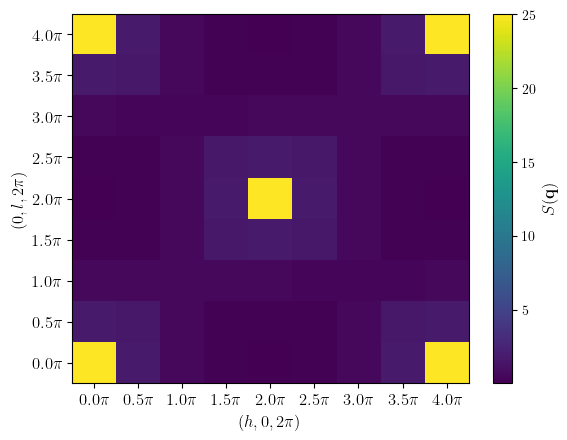

In [44]:
plt.imshow(
    Sq_plot.transpose(),
    extent=(
        qmin - deltaqx / 2,
        qmax + deltaqx / 2,
        qmin - deltaqy / 2,
        qmax + deltaqy / 2,
    ),
    origin="lower",
    aspect="auto",
)
cbar = plt.colorbar()
fsize = 12
plt.xlabel(r"$(h,0,2\pi)$", fontsize=fsize)
plt.ylabel(r"$(0,l,2\pi)$", fontsize=fsize)
plt.xticks(Qx, [f"{i / np.pi:.1f}" + r"$\pi$" for i in Qx], fontsize=fsize)
plt.yticks(Qy, [f"{i / np.pi:.1f}" + r"$\pi$" for i in Qy], fontsize=fsize)
cbar.set_label(r"$S(\mathbf{q})$", fontsize=fsize)
plt.show()

## 664

In [47]:
N = 288
base1 = data_dir + "raw_data/tetragonal/tet664_Jab/"
j1 = 1
jc = -4.9
jabs = (1, 1.025, 1.05)
min_runs = [3, 4, 5]
files = []
for i, jab in enumerate(jabs):
    files.append(base1 + f"{min_runs[i]}/continue0/continue0/final_exp.json")

results = []
systems = []
for i, jab in enumerate(jabs):
    with open(files[i], "r") as f:
        results.append(json.load(f))
        _, system, _, _, _ = load_opt(files[i].replace("final_exp.json", "opt.json"))
        systems.append(system)

Using simple cubic BCC lattice with lattice shape [6 6 4]
Momentum sector k = [0. 0. 0.]
Using little group irrep 0:
Little group elements: 
 ['Id()', 'Rot(180°)[0,0,1]', 'Rot(180°)[0,1,0]', 'Rot(180°)[1,0,0]', 'Rot(90°)[0,0,1]', 'Rot(90°)[0,0,-1]', 'Rot(180°)[1,-1,0]', 'Rot(180°)[-1,-1,0]', 'Inv()', 'Refl[0,0,1]', 'Refl[0,1,0]', 'Refl[1,0,0]', 'RotoRefl(90°)[0,0,-1]', 'RotoRefl(90°)[0,0,1]', 'Refl[1,-1,0]', 'Refl[1,1,0]']
Little group characters: 
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Momentum sector = (0.0, 0.0, 0.0)
Using simple cubic BCC lattice with lattice shape [6 6 4]
Momentum sector k = [0. 0. 0.]
Using little group irrep 0:
Little group elements: 
 ['Id()', 'Rot(180°)[0,0,1]', 'Rot(180°)[0,1,0]', 'Rot(180°)[1,0,0]', 'Rot(90°)[0,0,1]', 'Rot(90°)[0,0,-1]', 'Rot(180°)[1,-1,0]', 'Rot(180°)[-1,-1,0]', 'Inv()', 'Refl[0,0,1]', 'Refl[0,1,0]', 'Refl[1,0,0]', 'RotoRefl(90°)[0,0,-1]', 'RotoRefl(90°)[0,0,1]', 'Refl[1,-1,0]', 'Refl[1,1,0]']
Little group characters: 
 [1. 1. 1

In [48]:
n = 2
print(f"Jab = {jabs[n]}")
res = results[n]
SzSz, SzSz_error = get_spinspin(res, 2, N, string="SzSz_t")
SpSm, SpSm_error = get_spinspin(res, 2, N, string="SpSm_t")
SpSm, SpSm_error = 0.5 * np.array((SpSm, SpSm_error))
S_error = np.sqrt(SzSz_error**2 + SpSm_error**2)
scorr = SpinCorr(SzSz + SpSm, system.graph)
qmin, qmax = 0, 4 * np.pi
deltaqx = np.pi / 3
deltaqy = np.pi / 3
Qx = np.arange(qmin, qmax + 0.1, deltaqx)
Qy = np.arange(qmin, qmax + 0.1, deltaqy)
Qz = np.array([2 * np.pi / t])
Q = np.zeros((len(Qx), len(Qy), len(Qz), 3))
for i, qx in enumerate(Qx):
    for j, qy in enumerate(Qy):
        for k, qz in enumerate(Qz):
            Q[i, j, k] = np.array([qx, qy, qz])

S_q, _ = scorr.structure_factor(Q)
Sq_plot = np.zeros((len(Qx), len(Qy)))
for i, qx in enumerate(Qx):
    for j, qy in enumerate(Qy):
        Sq_plot[i, j] = S_q[i, j, 0]  # Take hl0 cut

Jab = 1.05
N_i != N_j, assuming S is (Nbasis, N) correlation matrix


/var/folders/q5/3th0qwt539db5yhyjt0j0c1w0000gp/T/ipykernel_7977/3076567420.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  Sq_plot[i,j] = S_q[i,j,0]  # Take hl0 cut


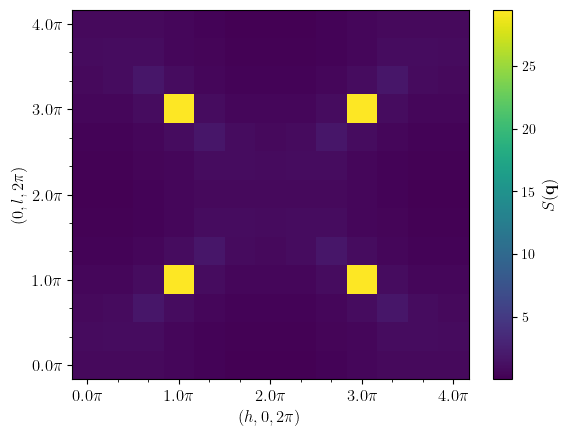

In [49]:
plt.imshow(
    Sq_plot.transpose(),
    extent=(
        qmin - deltaqx / 2,
        qmax + deltaqx / 2,
        qmin - deltaqy / 2,
        qmax + deltaqy / 2,
    ),
    origin="lower",
    aspect="auto",
)
cbar = plt.colorbar()
fsize = 12
plt.xlabel(r"$(h,0,2\pi)$", fontsize=fsize)
plt.ylabel(r"$(0,l,2\pi)$", fontsize=fsize)
qx_plot = np.pi * np.array([0, 1, 2, 3, 4])
qy_plot = np.pi * np.array([0, 1, 2, 3, 4])
plt.xticks(
    qx_plot,
    [f"{i / np.pi:.1f}" + r"$\pi$" for i in qx_plot],
    fontsize=fsize,
    minor=False,
)
plt.yticks(
    qy_plot,
    [f"{i / np.pi:.1f}" + r"$\pi$" for i in qy_plot],
    fontsize=fsize,
    minor=False,
)
plt.xticks(Qx, minor=True)
plt.yticks(Qy, minor=True)
cbar.set_label(r"$S(\mathbf{q})$", fontsize=fsize)
plt.show()